In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
%matplotlib inline

In [2]:
### SET UP THE SIMULATOR ###

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShear(pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb')), 
                                                           lmin = 10, lmax = 3000, n_ell_bins = 10, sigma_e = 0.3, 
                                                           nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args):
    return CosmicShearSimulator.simulate(theta, seed)
simulator_args = None

In [3]:
### SET UP THE PRIOR ###

# Define the priors parameters
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Prior
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Expected support of Wishart likelihood (fiducial inverse power spectrum)
C = CosmicShearSimulator.power_spectrum(theta_fiducial)
Cinv = np.array([np.linalg.inv(C[l,:,:]) for l in range(CosmicShearSimulator.n_ell_bins)])

# Degrees of freedom (effective number of modes per band power)
nl = CosmicShearSimulator.nl

# Calculate derivatives of the expected power spectrum
h = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = CosmicShearSimulator.compute_derivatives(theta_fiducial, h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Wishart(theta_fiducial, nl, Cinv, dCdt, prior_mean=prior_mean, prior_covariance=prior_covariance)

# Pull out Fisher matrix inverse
Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

In [6]:
print(dCdt.shape)

(5, 10, 10, 10)


In [5]:
### LOAD IN THE DATA VECTOR ###
data = compressor(simulator(theta_fiducial, 42, simulator_args), compressor_args)

In [ ]:
## Create the MAF
MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=5, n_outputs=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh)

In [ ]:
# Create the DELFI object
DelfiMAF = delfi.Delfi(data, prior, MAF, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results/")

Sample parameters:   1%|          | 1034/200000 [00:00<00:19, 10336.26it/s]

Generating fisher pre-training data...


Sample parameters: 100%|██████████| 200000/200000 [00:20<00:00, 9910.14it/s] 


Training the neural density estimator...


Epochs: 100%|██████████| 500/500 [1:56:33<00:00, 11.46s/it, train_loss=4, val_loss=4.02]     

Training finished
Best epoch 00498, Val_loss: 3.8594
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Done.
Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/fisher_pretrain_post.pdf


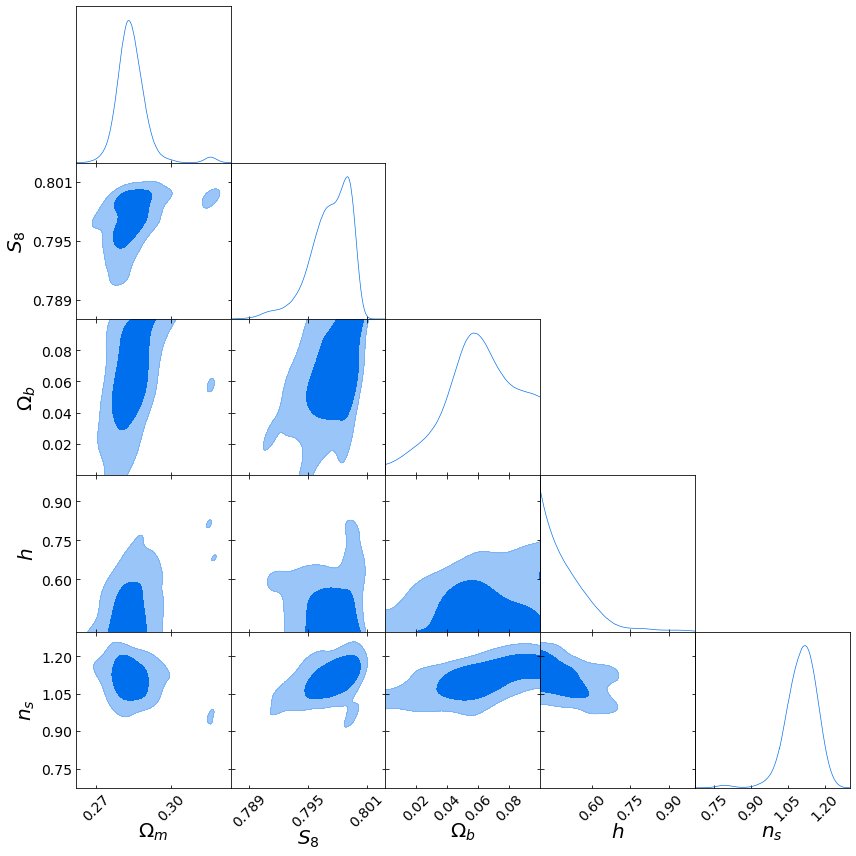

In [ ]:
# Do the Fisher pre-training
DelfiMAF.fisher_pretraining(200000, prior, epochs=500, patience=100)

Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Running initial 500 sims...


Simulations: 500it [04:03,  1.97it/s]                         
Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Done.



Epochs:  91%|█████████ | 91/100 [00:23<00:02,  3.77it/s, train_loss=7.44, val_loss=7.59]


Epochs: 100%|██████████| 100/100 [00:25<00:00,  3.79it/s, train_loss=7.28, val_loss=7.39]


Training finished
Best epoch 00098, Val_loss: 7.3945
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_0.pdf


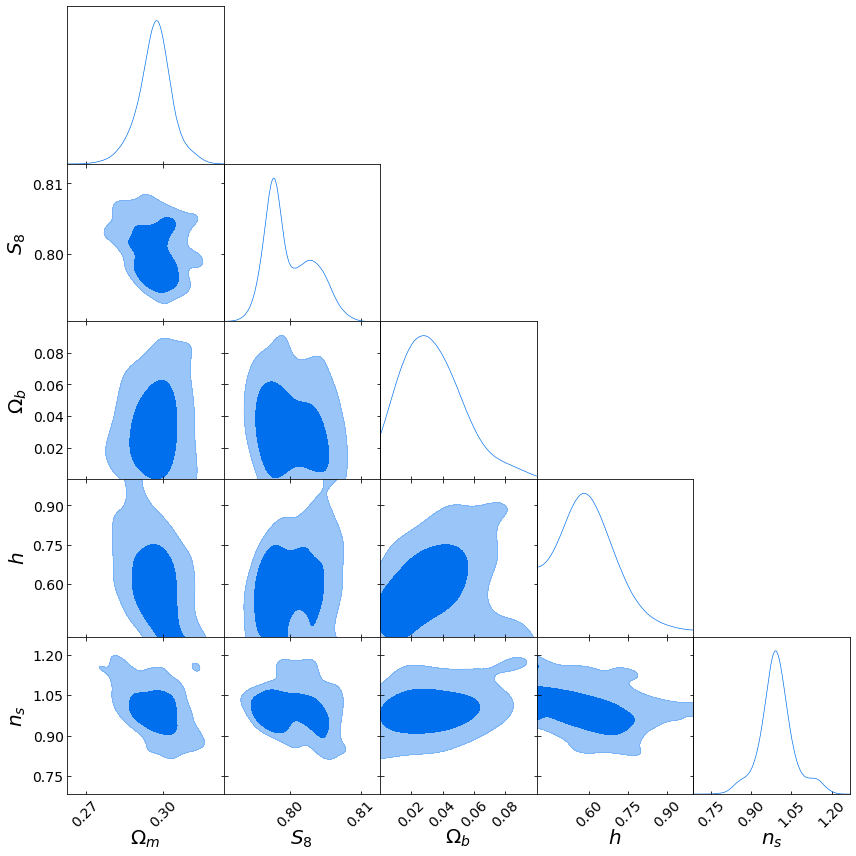

Population 1/23
Sampling proposal density...



Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...



Simulations:  50%|████▉     | 249/499 [02:00<02:03,  2.02it/s]


Simulations: 100%|█████████▉| 497/499 [04:01<00:01,  1.79it/s]


Simulations: 100%|██████████| 499/499 [04:02<00:00,  1.85it/s]
Simulations: 500it [04:03,  1.76it/s]                         

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Done.




Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=12.2, val_loss=11.6]

Epochs:   1%|          | 1/100 [00:00<00:36,  2.73it/s, train_loss=12.2, val_loss=11.6]

Epochs:   1%|          | 1/100 [00:00<00:36,  2.73it/s, train_loss=9.87, val_loss=10.2]

Epochs:   2%|▏         | 2/100 [00:00<00:32,  3.01it/s, train_loss=9.87, val_loss=10.2]

Epochs:   2%|▏         | 2/100 [00:00<00:32,  3.01it/s, train_loss=9.3, val_loss=9.68] 

Epochs:   3%|▎         | 3/100 [00:00<00:29,  3.25it/s, train_loss=9.3, val_loss=9.68]

Epochs:   3%|▎         | 3/100 [00:00<00:29,  3.25it/s, train_loss=8.95, val_loss=9.3]

Epochs:   4%|▍         | 4/100 [00:01<00:31,  3.04it/s, train_loss=8.95, val_loss=9.3]

Epochs:   4%|▍         | 4/100 [00:01<00:31,  3.04it/s, train_loss=8.84, val_loss=9.14]

Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.20it/s, train_loss=8.84, val_loss=9.14]

Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.20it/s, train_loss=8.73, val_loss=9.04]

Epochs:   6%|▌         | 6/100

Epochs:  91%|█████████ | 91/100 [00:21<00:01,  4.51it/s, train_loss=6.12, val_loss=6.99]

Epochs:  93%|█████████▎| 93/100 [00:21<00:01,  5.69it/s, train_loss=6.12, val_loss=6.99]

Epochs:  93%|█████████▎| 93/100 [00:21<00:01,  5.69it/s, train_loss=6.1, val_loss=6.93] 

Epochs:  93%|█████████▎| 93/100 [00:22<00:01,  5.69it/s, train_loss=6.08, val_loss=6.95]

Epochs:  95%|█████████▌| 95/100 [00:22<00:00,  6.86it/s, train_loss=6.08, val_loss=6.95]

Epochs:  95%|█████████▌| 95/100 [00:22<00:00,  6.86it/s, train_loss=6.06, val_loss=6.98]

Epochs:  95%|█████████▌| 95/100 [00:22<00:00,  6.86it/s, train_loss=6.05, val_loss=6.98]

Epochs:  97%|█████████▋| 97/100 [00:22<00:00,  8.12it/s, train_loss=6.05, val_loss=6.98]

Epochs:  97%|█████████▋| 97/100 [00:22<00:00,  8.12it/s, train_loss=6.03, val_loss=7.02]

Epochs:  97%|█████████▋| 97/100 [00:22<00:00,  8.12it/s, train_loss=6.01, val_loss=6.97]

Epochs:  99%|█████████▉| 99/100 [00:22<00:00,  9.43it/s, train_loss=6.01, val_loss=6.97]

Epochs:  9

Training finished
Best epoch 00098, Val_loss: 6.9329
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_1.pdf


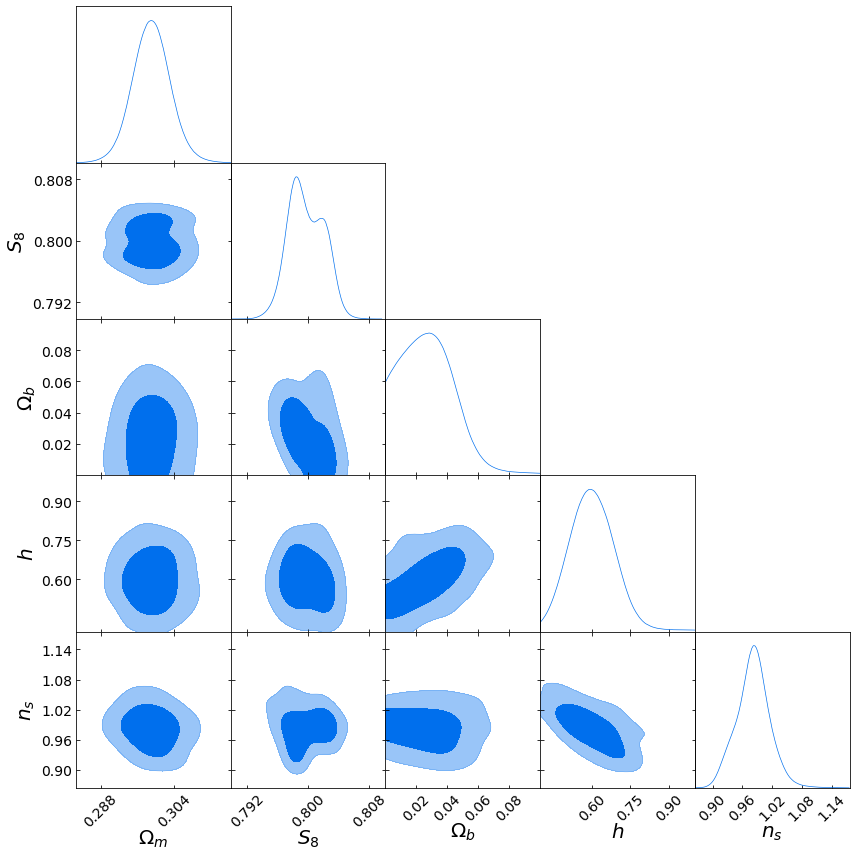

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


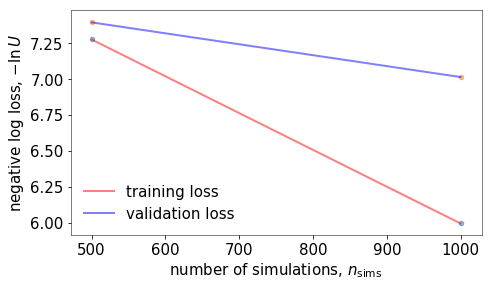

Population 2/23
Sampling proposal density...




Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...




Simulations:   0%|          | 1/499 [00:00<03:43,  2.23it/s]

Simulations:   0%|          | 2/499 [00:00<03:50,  2.15it/s]

Simulations:   1%|          | 3/499 [00:01<03:55,  2.11it/s]

Simulations:   1%|          | 4/499 [00:01<03:53,  2.12it/s]

Simulations:   1%|          | 5/499 [00:02<03:54,  2.10it/s]

Simulations:   1%|          | 6/499 [00:03<04:15,  1.93it/s]

Simulations:   1%|▏         | 7/499 [00:03<04:13,  1.94it/s]

Simulations:   2%|▏         | 8/499 [00:04<04:08,  1.98it/s]

Simulations:   2%|▏         | 9/499 [00:04<04:02,  2.02it/s]

Simulations:   2%|▏         | 10/499 [00:04<03:57,  2.06it/s]

Simulations:   2%|▏         | 11/499 [00:05<03:53,  2.09it/s]

Simulations:   2%|▏         | 12/499 [00:05<03:51,  2.11it/s]

Simulations:   3%|▎         | 13/499 [00:06<03:57,  2.05it/s]

Simulations:   3%|▎         | 14/499 [00:06<03:54,  2.07it/s]

Simulations:   3%|▎         | 15/499 [00:07<03:56,  2.04it/s]

Simulations:   3%|▎         | 16/499 [00:07<03:54,  2.06it/s]


Simulations:  47%|████▋     | 236/499 [01:52<02:19,  1.89it/s]

Simulations:  47%|████▋     | 237/499 [01:53<02:17,  1.91it/s]

Simulations:  48%|████▊     | 238/499 [01:53<02:09,  2.01it/s]

Simulations:  48%|████▊     | 239/499 [01:54<02:03,  2.10it/s]

Simulations:  48%|████▊     | 240/499 [01:54<02:00,  2.15it/s]

Simulations:  48%|████▊     | 241/499 [01:54<01:58,  2.18it/s]

Simulations:  48%|████▊     | 242/499 [01:55<01:59,  2.15it/s]

Simulations:  49%|████▊     | 243/499 [01:56<02:07,  2.02it/s]

Simulations:  49%|████▉     | 244/499 [01:56<02:13,  1.92it/s]

Simulations:  49%|████▉     | 245/499 [01:57<02:09,  1.96it/s]

Simulations:  49%|████▉     | 246/499 [01:57<02:06,  1.99it/s]

Simulations:  49%|████▉     | 247/499 [01:58<02:04,  2.03it/s]

Simulations:  50%|████▉     | 248/499 [01:58<02:04,  2.02it/s]

Simulations:  50%|████▉     | 249/499 [01:59<02:03,  2.02it/s]

Simulations:  50%|█████     | 250/499 [01:59<02:01,  2.04it/s]

Simulations:  50%|█████     | 251/499 [0

Simulations:  94%|█████████▍| 470/499 [03:50<00:14,  2.06it/s]

Simulations:  94%|█████████▍| 471/499 [03:50<00:13,  2.05it/s]

Simulations:  95%|█████████▍| 472/499 [03:51<00:13,  2.02it/s]

Simulations:  95%|█████████▍| 473/499 [03:51<00:12,  2.05it/s]

Simulations:  95%|█████████▍| 474/499 [03:52<00:11,  2.08it/s]

Simulations:  95%|█████████▌| 475/499 [03:52<00:11,  2.11it/s]

Simulations:  95%|█████████▌| 476/499 [03:53<00:10,  2.11it/s]

Simulations:  96%|█████████▌| 477/499 [03:53<00:10,  2.11it/s]

Simulations:  96%|█████████▌| 478/499 [03:54<00:09,  2.15it/s]

Simulations:  96%|█████████▌| 479/499 [03:54<00:09,  2.14it/s]

Simulations:  96%|█████████▌| 480/499 [03:55<00:08,  2.11it/s]

Simulations:  96%|█████████▋| 481/499 [03:55<00:08,  2.08it/s]

Simulations:  97%|█████████▋| 482/499 [03:56<00:08,  2.08it/s]

Simulations:  97%|█████████▋| 483/499 [03:56<00:07,  2.10it/s]

Simulations:  97%|█████████▋| 484/499 [03:57<00:07,  2.12it/s]

Simulations:  97%|█████████▋| 485/499 [0

Done.





Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=6.85, val_loss=6.68]


Epochs:   1%|          | 1/100 [00:00<00:38,  2.58it/s, train_loss=6.85, val_loss=6.68]


Epochs:   1%|          | 1/100 [00:00<00:38,  2.58it/s, train_loss=6.74, val_loss=6.63]


Epochs:   2%|▏         | 2/100 [00:00<00:34,  2.86it/s, train_loss=6.74, val_loss=6.63]


Epochs:   2%|▏         | 2/100 [00:00<00:34,  2.86it/s, train_loss=6.68, val_loss=6.6] 


Epochs:   3%|▎         | 3/100 [00:00<00:31,  3.10it/s, train_loss=6.68, val_loss=6.6]


Epochs:   3%|▎         | 3/100 [00:00<00:31,  3.10it/s, train_loss=6.64, val_loss=6.58]


Epochs:   4%|▍         | 4/100 [00:01<00:30,  3.17it/s, train_loss=6.64, val_loss=6.58]


Epochs:   4%|▍         | 4/100 [00:01<00:30,  3.17it/s, train_loss=6.59, val_loss=6.54]


Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.23it/s, train_loss=6.59, val_loss=6.54]


Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.23it/s, train_loss=6.55, val_loss=6.51]


Epochs:   6%|▌  

Epochs:  93%|█████████▎| 93/100 [00:21<00:01,  5.33it/s, train_loss=5.02, val_loss=5.33]


Epochs:  93%|█████████▎| 93/100 [00:21<00:01,  5.33it/s, train_loss=5.05, val_loss=5.35]


Epochs:  93%|█████████▎| 93/100 [00:21<00:01,  5.33it/s, train_loss=5.01, val_loss=5.31]


Epochs:  95%|█████████▌| 95/100 [00:21<00:00,  5.62it/s, train_loss=5.01, val_loss=5.31]


Epochs:  95%|█████████▌| 95/100 [00:21<00:00,  5.62it/s, train_loss=4.98, val_loss=5.33]


Epochs:  95%|█████████▌| 95/100 [00:21<00:00,  5.62it/s, train_loss=4.96, val_loss=5.34]


Epochs:  97%|█████████▋| 97/100 [00:21<00:00,  6.83it/s, train_loss=4.96, val_loss=5.34]


Epochs:  97%|█████████▋| 97/100 [00:21<00:00,  6.83it/s, train_loss=4.96, val_loss=5.31]


Epochs:  98%|█████████▊| 98/100 [00:22<00:00,  5.63it/s, train_loss=4.96, val_loss=5.31]


Epochs:  98%|█████████▊| 98/100 [00:22<00:00,  5.63it/s, train_loss=4.94, val_loss=5.33]


Epochs:  98%|█████████▊| 98/100 [00:22<00:00,  5.63it/s, train_loss=4.95, val_loss=5.3] 



Training finished
Best epoch 00098, Val_loss: 5.3038
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_2.pdf


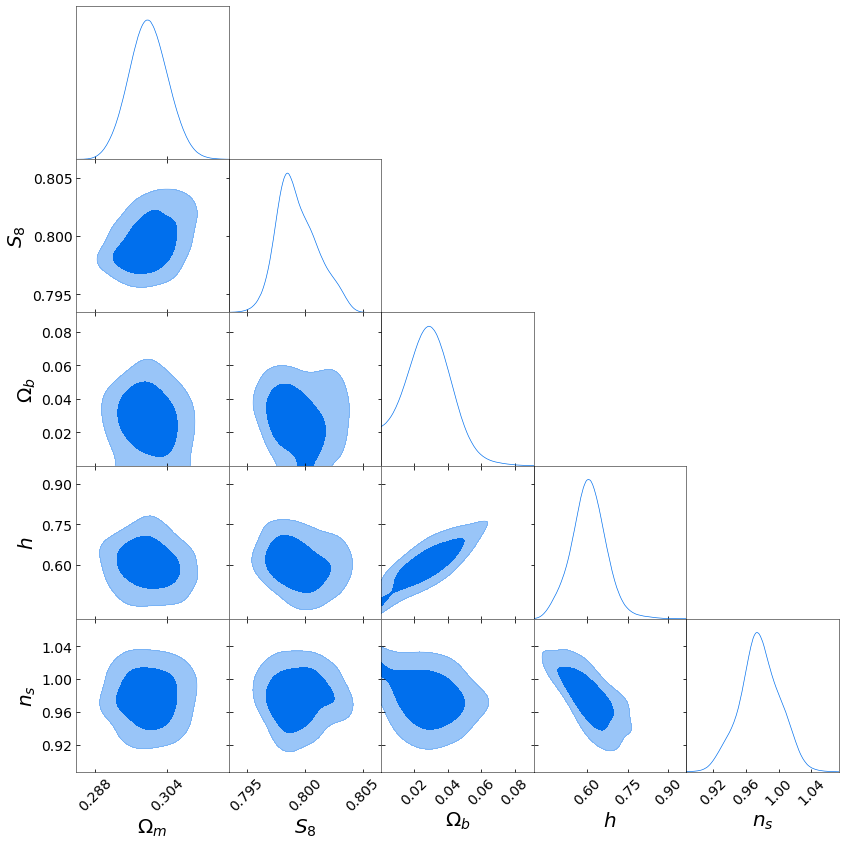

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


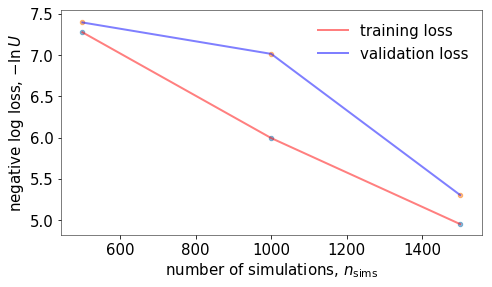

Population 3/23
Sampling proposal density...





Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...





Simulations:   0%|          | 1/499 [00:00<04:54,  1.69it/s]


Simulations:   0%|          | 2/499 [00:01<04:51,  1.70it/s]


Simulations:   1%|          | 3/499 [00:01<04:52,  1.69it/s]


Simulations:   1%|          | 4/499 [00:02<04:37,  1.79it/s]


Simulations:   1%|          | 5/499 [00:02<04:33,  1.81it/s]


Simulations:   1%|          | 6/499 [00:03<04:20,  1.90it/s]


Simulations:   1%|▏         | 7/499 [00:03<04:24,  1.86it/s]


Simulations:   2%|▏         | 8/499 [00:04<04:14,  1.93it/s]


Simulations:   2%|▏         | 9/499 [00:04<04:02,  2.02it/s]


Simulations:   2%|▏         | 10/499 [00:05<03:53,  2.10it/s]


Simulations:   2%|▏         | 11/499 [00:05<03:44,  2.17it/s]


Simulations:   2%|▏         | 12/499 [00:06<03:38,  2.23it/s]


Simulations:   3%|▎         | 13/499 [00:06<03:34,  2.26it/s]


Simulations:   3%|▎         | 14/499 [00:06<03:35,  2.26it/s]


Simulations:   3%|▎         | 15/499 [00:07<03:53,  2.08it/s]


Simulations:   3%|▎         | 16/499 [00:08<04

Simulations:  45%|████▍     | 223/499 [01:42<02:31,  1.82it/s]


Simulations:  45%|████▍     | 224/499 [01:43<02:29,  1.84it/s]


Simulations:  45%|████▌     | 225/499 [01:43<02:25,  1.88it/s]


Simulations:  45%|████▌     | 226/499 [01:44<02:16,  2.00it/s]


Simulations:  45%|████▌     | 227/499 [01:44<02:18,  1.96it/s]


Simulations:  46%|████▌     | 228/499 [01:45<02:14,  2.01it/s]


Simulations:  46%|████▌     | 229/499 [01:45<02:09,  2.09it/s]


Simulations:  46%|████▌     | 230/499 [01:46<02:03,  2.18it/s]


Simulations:  46%|████▋     | 231/499 [01:46<01:59,  2.24it/s]


Simulations:  46%|████▋     | 232/499 [01:47<02:08,  2.08it/s]


Simulations:  47%|████▋     | 233/499 [01:47<02:11,  2.02it/s]


Simulations:  47%|████▋     | 234/499 [01:48<02:08,  2.06it/s]


Simulations:  47%|████▋     | 235/499 [01:48<02:03,  2.13it/s]


Simulations:  47%|████▋     | 236/499 [01:49<02:00,  2.18it/s]


Simulations:  47%|████▋     | 237/499 [01:49<01:58,  2.21it/s]


Simulations:  48%|████▊  

Simulations:  89%|████████▉ | 443/499 [03:33<00:29,  1.88it/s]


Simulations:  89%|████████▉ | 444/499 [03:34<00:28,  1.93it/s]


Simulations:  89%|████████▉ | 445/499 [03:34<00:29,  1.81it/s]


Simulations:  89%|████████▉ | 446/499 [03:35<00:28,  1.84it/s]


Simulations:  90%|████████▉ | 447/499 [03:35<00:27,  1.88it/s]


Simulations:  90%|████████▉ | 448/499 [03:36<00:26,  1.89it/s]


Simulations:  90%|████████▉ | 449/499 [03:36<00:25,  1.98it/s]


Simulations:  90%|█████████ | 450/499 [03:37<00:24,  2.04it/s]


Simulations:  90%|█████████ | 451/499 [03:37<00:22,  2.10it/s]


Simulations:  91%|█████████ | 452/499 [03:38<00:21,  2.16it/s]


Simulations:  91%|█████████ | 453/499 [03:38<00:20,  2.20it/s]


Simulations:  91%|█████████ | 454/499 [03:39<00:21,  2.05it/s]


Simulations:  91%|█████████ | 455/499 [03:39<00:20,  2.17it/s]


Simulations:  91%|█████████▏| 456/499 [03:40<00:19,  2.23it/s]


Simulations:  92%|█████████▏| 457/499 [03:40<00:18,  2.24it/s]


Simulations:  92%|███████

Done.






Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=5.21, val_loss=5.62]



Epochs:   1%|          | 1/100 [00:00<00:35,  2.82it/s, train_loss=5.21, val_loss=5.62]



Epochs:   1%|          | 1/100 [00:00<00:35,  2.82it/s, train_loss=5.12, val_loss=5.56]



Epochs:   2%|▏         | 2/100 [00:00<00:33,  2.95it/s, train_loss=5.12, val_loss=5.56]



Epochs:   2%|▏         | 2/100 [00:00<00:33,  2.95it/s, train_loss=5.1, val_loss=5.54] 



Epochs:   3%|▎         | 3/100 [00:00<00:31,  3.08it/s, train_loss=5.1, val_loss=5.54]



Epochs:   3%|▎         | 3/100 [00:01<00:31,  3.08it/s, train_loss=5.07, val_loss=5.53]



Epochs:   4%|▍         | 4/100 [00:01<00:29,  3.20it/s, train_loss=5.07, val_loss=5.53]



Epochs:   4%|▍         | 4/100 [00:01<00:29,  3.20it/s, train_loss=5.21, val_loss=5.6] 



Epochs:   4%|▍         | 4/100 [00:01<00:29,  3.20it/s, train_loss=5.07, val_loss=5.51]



Epochs:   6%|▌         | 6/100 [00:01<00:25,  3.62it/s, train_loss=5.07, val_loss=5.51]



Epoc

Training finished
Best epoch 00039, Val_loss: 5.3989
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...






Epochs:  39%|███▉      | 39/100 [00:22<00:05, 11.42it/s, train_loss=4.64, val_loss=5.42]

Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_3.pdf


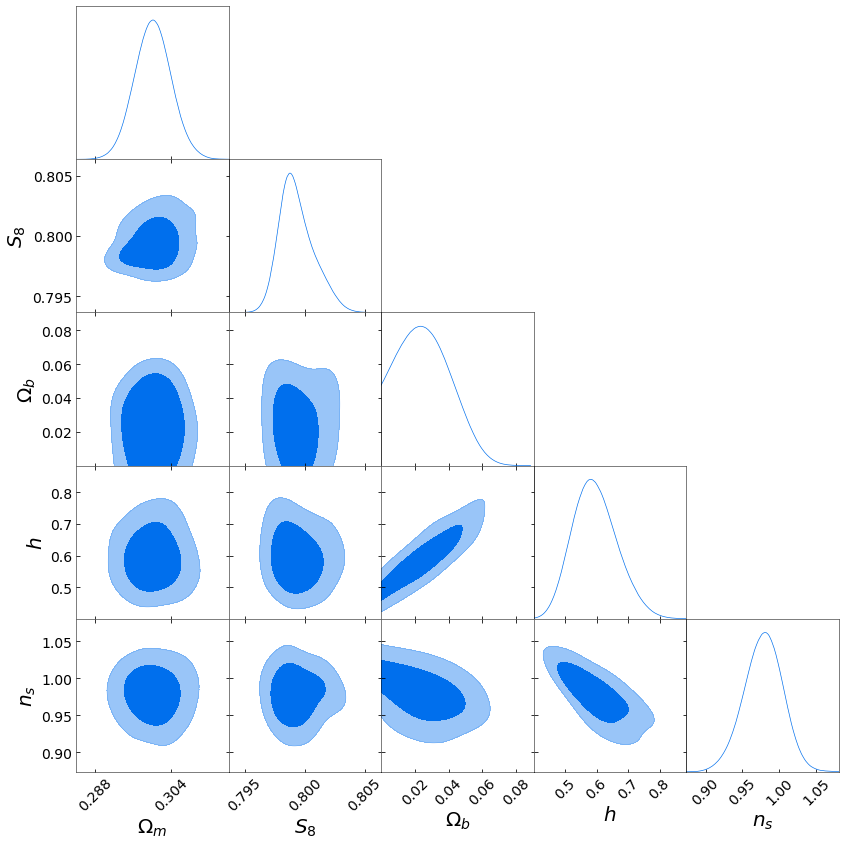

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


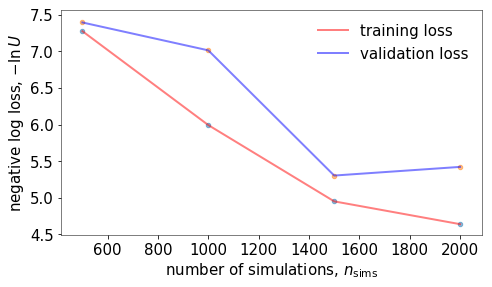

Population 4/23
Sampling proposal density...







Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...







Simulations:   0%|          | 1/499 [00:00<04:22,  1.90it/s]




Simulations:   0%|          | 2/499 [00:00<04:09,  1.99it/s]




Simulations:   1%|          | 3/499 [00:01<03:57,  2.09it/s]




Simulations:   1%|          | 4/499 [00:01<03:49,  2.15it/s]




Simulations:   1%|          | 5/499 [00:02<03:45,  2.19it/s]




Simulations:   1%|          | 6/499 [00:02<04:01,  2.04it/s]




Simulations:   1%|▏         | 7/499 [00:03<04:04,  2.01it/s]




Simulations:   2%|▏         | 8/499 [00:03<03:59,  2.05it/s]




Simulations:   2%|▏         | 9/499 [00:04<03:56,  2.07it/s]




Simulations:   2%|▏         | 10/499 [00:04<03:55,  2.08it/s]




Simulations:   2%|▏         | 11/499 [00:05<03:55,  2.07it/s]




Simulations:   2%|▏         | 12/499 [00:05<03:55,  2.07it/s]




Simulations:   3%|▎         | 13/499 [00:06<03:57,  2.05it/s]




Simulations:   3%|▎         | 14/499 [00:06<03:55,  2.06it/s]




Simulations:   3%|▎         | 15/499 [00:07<03:54,  2.06it/s]




Simulations:  

Simulations:  40%|████      | 201/499 [01:35<02:13,  2.23it/s]




Simulations:  40%|████      | 202/499 [01:35<02:14,  2.21it/s]




Simulations:  41%|████      | 203/499 [01:36<02:13,  2.22it/s]




Simulations:  41%|████      | 204/499 [01:36<02:16,  2.16it/s]




Simulations:  41%|████      | 205/499 [01:37<02:30,  1.95it/s]




Simulations:  41%|████▏     | 206/499 [01:37<02:35,  1.88it/s]




Simulations:  41%|████▏     | 207/499 [01:38<02:29,  1.95it/s]




Simulations:  42%|████▏     | 208/499 [01:38<02:25,  2.01it/s]




Simulations:  42%|████▏     | 209/499 [01:39<02:19,  2.08it/s]




Simulations:  42%|████▏     | 210/499 [01:39<02:13,  2.17it/s]




Simulations:  42%|████▏     | 211/499 [01:40<02:08,  2.24it/s]




Simulations:  42%|████▏     | 212/499 [01:40<02:08,  2.23it/s]




Simulations:  43%|████▎     | 213/499 [01:41<02:09,  2.21it/s]




Simulations:  43%|████▎     | 214/499 [01:41<02:09,  2.20it/s]




Simulations:  43%|████▎     | 215/499 [01:41<02:07,  2.23it/s]

Simulations:  80%|███████▉  | 399/499 [03:14<00:53,  1.86it/s]




Simulations:  80%|████████  | 400/499 [03:15<00:52,  1.88it/s]




Simulations:  80%|████████  | 401/499 [03:15<00:51,  1.91it/s]




Simulations:  81%|████████  | 402/499 [03:16<00:51,  1.89it/s]




Simulations:  81%|████████  | 403/499 [03:16<00:49,  1.93it/s]




Simulations:  81%|████████  | 404/499 [03:17<00:51,  1.84it/s]




Simulations:  81%|████████  | 405/499 [03:18<00:52,  1.80it/s]




Simulations:  81%|████████▏ | 406/499 [03:18<00:49,  1.89it/s]




Simulations:  82%|████████▏ | 407/499 [03:18<00:47,  1.92it/s]




Simulations:  82%|████████▏ | 408/499 [03:19<00:49,  1.84it/s]




Simulations:  82%|████████▏ | 409/499 [03:20<00:48,  1.87it/s]




Simulations:  82%|████████▏ | 410/499 [03:20<00:46,  1.90it/s]




Simulations:  82%|████████▏ | 411/499 [03:21<00:45,  1.94it/s]




Simulations:  83%|████████▎ | 412/499 [03:21<00:44,  1.96it/s]




Simulations:  83%|████████▎ | 413/499 [03:22<00:43,  1.98it/s]

Done.








Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=5.18, val_loss=5.24]





Epochs:   1%|          | 1/100 [00:00<00:43,  2.25it/s, train_loss=5.18, val_loss=5.24]





Epochs:   1%|          | 1/100 [00:00<00:43,  2.25it/s, train_loss=5.04, val_loss=5.16]





Epochs:   2%|▏         | 2/100 [00:00<00:39,  2.45it/s, train_loss=5.04, val_loss=5.16]





Epochs:   2%|▏         | 2/100 [00:00<00:39,  2.45it/s, train_loss=4.98, val_loss=5.15]





Epochs:   3%|▎         | 3/100 [00:01<00:37,  2.59it/s, train_loss=4.98, val_loss=5.15]





Epochs:   3%|▎         | 3/100 [00:01<00:37,  2.59it/s, train_loss=4.9, val_loss=5.07] 





Epochs:   4%|▍         | 4/100 [00:01<00:35,  2.71it/s, train_loss=4.9, val_loss=5.07]





Epochs:   4%|▍         | 4/100 [00:01<00:35,  2.71it/s, train_loss=4.87, val_loss=4.99]





Epochs:   5%|▌         | 5/100 [00:01<00:34,  2.76it/s, train_loss=4.87, val_loss=4.99]





Epochs:   5%|▌         | 5/100 [00:01<00:34,  2.76it/s, train_loss=4.83, 

Training finished
Best epoch 00040, Val_loss: 4.8303
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model








Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_4.pdf


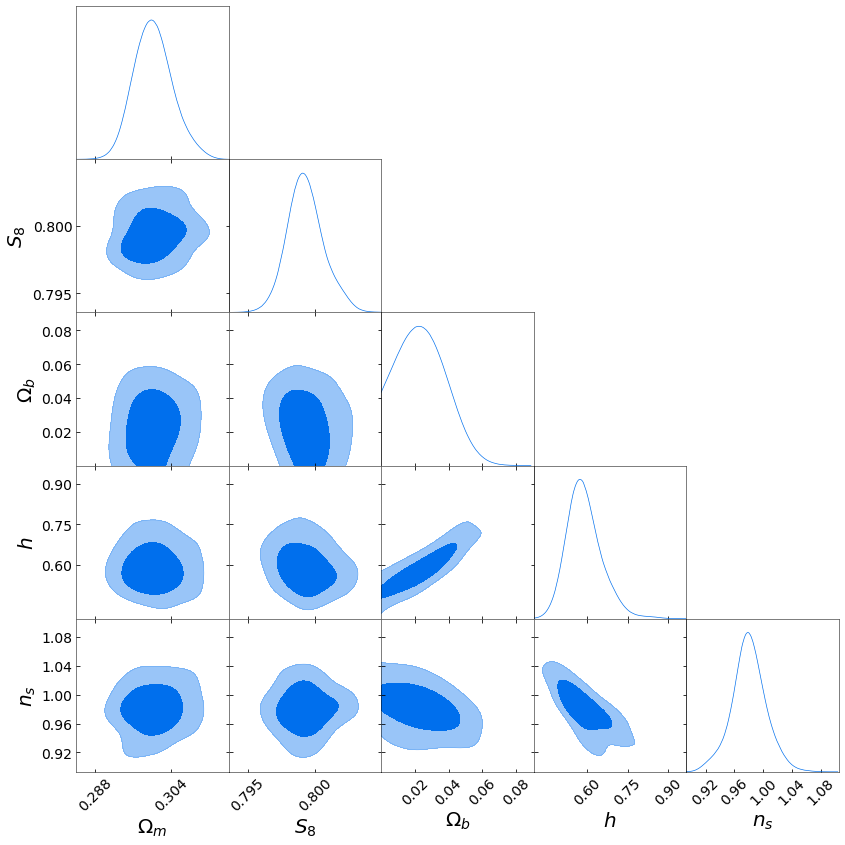

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


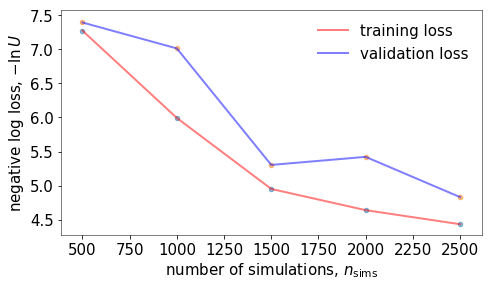

Population 5/23
Sampling proposal density...








Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...








Simulations:   0%|          | 1/499 [00:00<04:22,  1.89it/s]





Simulations:   0%|          | 2/499 [00:00<04:11,  1.98it/s]





Simulations:   1%|          | 3/499 [00:01<03:58,  2.08it/s]





Simulations:   1%|          | 4/499 [00:01<03:51,  2.14it/s]





Simulations:   1%|          | 5/499 [00:02<04:06,  2.00it/s]





Simulations:   1%|          | 6/499 [00:02<04:14,  1.94it/s]





Simulations:   1%|▏         | 7/499 [00:03<04:01,  2.04it/s]





Simulations:   2%|▏         | 8/499 [00:03<03:53,  2.10it/s]





Simulations:   2%|▏         | 9/499 [00:04<03:47,  2.16it/s]





Simulations:   2%|▏         | 10/499 [00:04<04:02,  2.02it/s]





Simulations:   2%|▏         | 11/499 [00:05<03:58,  2.05it/s]





Simulations:   2%|▏         | 12/499 [00:05<03:53,  2.08it/s]





Simulations:   3%|▎         | 13/499 [00:06<03:46,  2.14it/s]





Simulations:   3%|▎         | 14/499 [00:06<03:41,  2.19it/s]





Simulations:   3%|▎         | 15/499 [00:07<03:37,  2.22it/s]





Simulations:  38%|███▊      | 192/499 [01:34<02:28,  2.07it/s]





Simulations:  39%|███▊      | 193/499 [01:34<02:28,  2.06it/s]





Simulations:  39%|███▉      | 194/499 [01:35<02:27,  2.07it/s]





Simulations:  39%|███▉      | 195/499 [01:35<02:27,  2.06it/s]





Simulations:  39%|███▉      | 196/499 [01:36<02:33,  1.98it/s]





Simulations:  39%|███▉      | 197/499 [01:36<02:36,  1.93it/s]





Simulations:  40%|███▉      | 198/499 [01:37<02:33,  1.96it/s]





Simulations:  40%|███▉      | 199/499 [01:37<02:31,  1.99it/s]





Simulations:  40%|████      | 200/499 [01:38<02:28,  2.02it/s]





Simulations:  40%|████      | 201/499 [01:38<02:27,  2.02it/s]





Simulations:  40%|████      | 202/499 [01:39<02:26,  2.03it/s]





Simulations:  41%|████      | 203/499 [01:39<02:24,  2.05it/s]





Simulations:  41%|████      | 204/499 [01:40<02:22,  2.07it/s]





Simulations:  41%|████      | 205/499 [01:40<02:22,  2.06it/s]





Simulations:  41%|████▏     | 206/499 [01:41<02:

Simulations:  77%|███████▋  | 382/499 [03:06<00:54,  2.15it/s]





Simulations:  77%|███████▋  | 383/499 [03:06<00:53,  2.17it/s]





Simulations:  77%|███████▋  | 384/499 [03:07<00:52,  2.21it/s]





Simulations:  77%|███████▋  | 385/499 [03:07<00:50,  2.25it/s]





Simulations:  77%|███████▋  | 386/499 [03:08<00:50,  2.24it/s]





Simulations:  78%|███████▊  | 387/499 [03:08<00:49,  2.25it/s]





Simulations:  78%|███████▊  | 388/499 [03:08<00:49,  2.24it/s]





Simulations:  78%|███████▊  | 389/499 [03:09<00:48,  2.26it/s]





Simulations:  78%|███████▊  | 390/499 [03:09<00:48,  2.25it/s]





Simulations:  78%|███████▊  | 391/499 [03:10<00:48,  2.23it/s]





Simulations:  79%|███████▊  | 392/499 [03:10<00:47,  2.25it/s]





Simulations:  79%|███████▉  | 393/499 [03:11<00:46,  2.29it/s]





Simulations:  79%|███████▉  | 394/499 [03:11<00:44,  2.34it/s]





Simulations:  79%|███████▉  | 395/499 [03:11<00:44,  2.35it/s]





Simulations:  79%|███████▉  | 396/499 [03:12<00:

Done.









Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=4.58, val_loss=4.32]






Epochs:   1%|          | 1/100 [00:00<00:43,  2.25it/s, train_loss=4.58, val_loss=4.32]






Epochs:   1%|          | 1/100 [00:00<00:43,  2.25it/s, train_loss=4.56, val_loss=4.32]






Epochs:   1%|          | 1/100 [00:00<00:43,  2.25it/s, train_loss=4.56, val_loss=4.33]






Epochs:   3%|▎         | 3/100 [00:00<00:32,  2.99it/s, train_loss=4.56, val_loss=4.33]






Epochs:   3%|▎         | 3/100 [00:00<00:32,  2.99it/s, train_loss=4.56, val_loss=4.37]






Epochs:   3%|▎         | 3/100 [00:00<00:32,  2.99it/s, train_loss=4.54, val_loss=4.36]






Epochs:   5%|▌         | 5/100 [00:00<00:24,  3.84it/s, train_loss=4.54, val_loss=4.36]






Epochs:   5%|▌         | 5/100 [00:00<00:24,  3.84it/s, train_loss=4.53, val_loss=4.35]






Epochs:   5%|▌         | 5/100 [00:00<00:24,  3.84it/s, train_loss=4.5, val_loss=4.34] 






Epochs:   7%|▋         | 7/100 [00:00<00:19,  4.85it/s, train

Training finished
Best epoch 00009, Val_loss: 4.3213
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model









Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_5.pdf


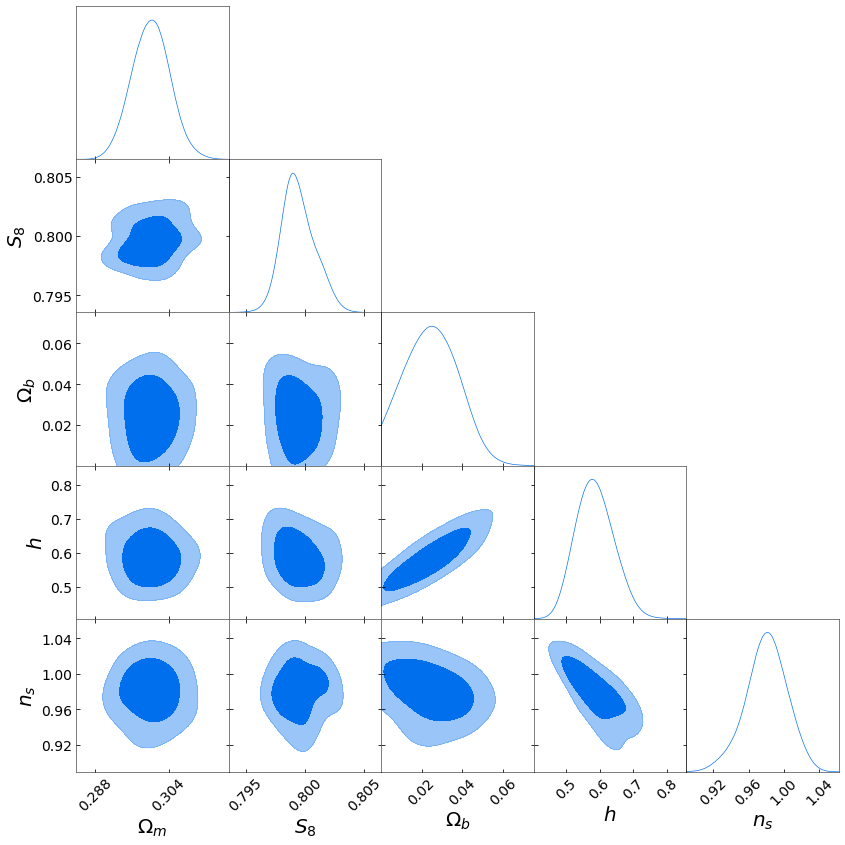

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


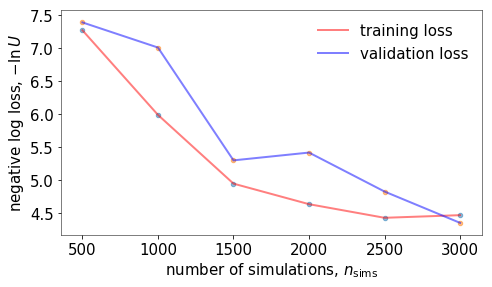

Population 6/23
Sampling proposal density...









Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...









Simulations:   0%|          | 1/499 [00:00<04:51,  1.71it/s]






Simulations:   0%|          | 2/499 [00:01<04:38,  1.78it/s]






Simulations:   1%|          | 3/499 [00:01<04:29,  1.84it/s]






Simulations:   1%|          | 4/499 [00:02<04:27,  1.85it/s]






Simulations:   1%|          | 5/499 [00:02<04:19,  1.90it/s]






Simulations:   1%|          | 6/499 [00:03<04:13,  1.94it/s]






Simulations:   1%|▏         | 7/499 [00:03<04:10,  1.96it/s]






Simulations:   2%|▏         | 8/499 [00:04<04:11,  1.96it/s]






Simulations:   2%|▏         | 9/499 [00:04<04:08,  1.98it/s]






Simulations:   2%|▏         | 10/499 [00:05<04:13,  1.93it/s]






Simulations:   2%|▏         | 11/499 [00:05<04:07,  1.97it/s]






Simulations:   2%|▏         | 12/499 [00:06<03:56,  2.06it/s]






Simulations:   3%|▎         | 13/499 [00:06<04:02,  2.00it/s]






Simulations:   3%|▎         | 14/499 [00:07<04:00,  2.02it/s]






Simulations:   3%|▎         | 15/499 [00:07<03:54,

Simulations:  37%|███▋      | 184/499 [01:29<02:34,  2.03it/s]






Simulations:  37%|███▋      | 185/499 [01:30<02:32,  2.05it/s]






Simulations:  37%|███▋      | 186/499 [01:30<02:32,  2.05it/s]






Simulations:  37%|███▋      | 187/499 [01:31<02:32,  2.05it/s]






Simulations:  38%|███▊      | 188/499 [01:31<02:30,  2.06it/s]






Simulations:  38%|███▊      | 189/499 [01:31<02:29,  2.07it/s]






Simulations:  38%|███▊      | 190/499 [01:32<02:29,  2.07it/s]






Simulations:  38%|███▊      | 191/499 [01:32<02:29,  2.06it/s]






Simulations:  38%|███▊      | 192/499 [01:33<02:28,  2.06it/s]






Simulations:  39%|███▊      | 193/499 [01:33<02:29,  2.05it/s]






Simulations:  39%|███▉      | 194/499 [01:34<02:28,  2.05it/s]






Simulations:  39%|███▉      | 195/499 [01:34<02:28,  2.05it/s]






Simulations:  39%|███▉      | 196/499 [01:35<02:29,  2.03it/s]






Simulations:  39%|███▉      | 197/499 [01:35<02:28,  2.03it/s]






Simulations:  40%|███▉      | 198/

Simulations:  73%|███████▎  | 366/499 [02:58<00:58,  2.27it/s]






Simulations:  74%|███████▎  | 367/499 [02:59<00:58,  2.26it/s]






Simulations:  74%|███████▎  | 368/499 [02:59<00:57,  2.27it/s]






Simulations:  74%|███████▍  | 369/499 [03:00<00:56,  2.29it/s]






Simulations:  74%|███████▍  | 370/499 [03:00<00:56,  2.29it/s]






Simulations:  74%|███████▍  | 371/499 [03:00<00:56,  2.27it/s]






Simulations:  75%|███████▍  | 372/499 [03:01<00:56,  2.26it/s]






Simulations:  75%|███████▍  | 373/499 [03:01<00:54,  2.30it/s]






Simulations:  75%|███████▍  | 374/499 [03:02<00:53,  2.32it/s]






Simulations:  75%|███████▌  | 375/499 [03:02<00:53,  2.32it/s]






Simulations:  75%|███████▌  | 376/499 [03:03<00:52,  2.33it/s]






Simulations:  76%|███████▌  | 377/499 [03:03<00:52,  2.34it/s]






Simulations:  76%|███████▌  | 378/499 [03:04<00:53,  2.27it/s]






Simulations:  76%|███████▌  | 379/499 [03:04<00:56,  2.11it/s]






Simulations:  76%|███████▌  | 380/

Done.










Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=4.59, val_loss=4.9]







Epochs:   1%|          | 1/100 [00:00<00:41,  2.36it/s, train_loss=4.59, val_loss=4.9]







Epochs:   1%|          | 1/100 [00:00<00:41,  2.36it/s, train_loss=4.59, val_loss=4.89]







Epochs:   2%|▏         | 2/100 [00:00<00:39,  2.45it/s, train_loss=4.59, val_loss=4.89]







Epochs:   2%|▏         | 2/100 [00:00<00:39,  2.45it/s, train_loss=4.57, val_loss=4.87]







Epochs:   3%|▎         | 3/100 [00:01<00:37,  2.58it/s, train_loss=4.57, val_loss=4.87]







Epochs:   3%|▎         | 3/100 [00:01<00:37,  2.58it/s, train_loss=4.54, val_loss=4.86]







Epochs:   4%|▍         | 4/100 [00:01<00:41,  2.31it/s, train_loss=4.54, val_loss=4.86]







Epochs:   4%|▍         | 4/100 [00:01<00:41,  2.31it/s, train_loss=4.53, val_loss=4.83]







Epochs:   5%|▌         | 5/100 [00:02<00:39,  2.40it/s, train_loss=4.53, val_loss=4.83]







Epochs:   5%|▌         | 5/100 [00:02<00:39,  2.40it

Training finished
Best epoch 00078, Val_loss: 4.6679
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...










Epochs:  78%|███████▊  | 78/100 [00:25<00:02, 10.05it/s, train_loss=4.1, val_loss=4.73]

Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_6.pdf


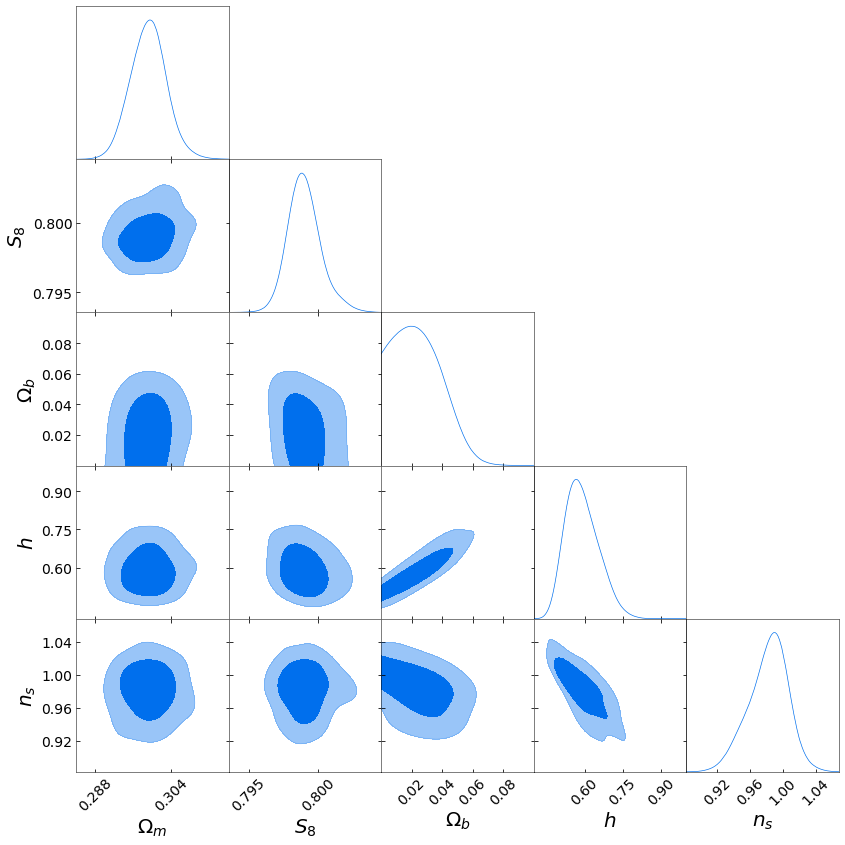

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


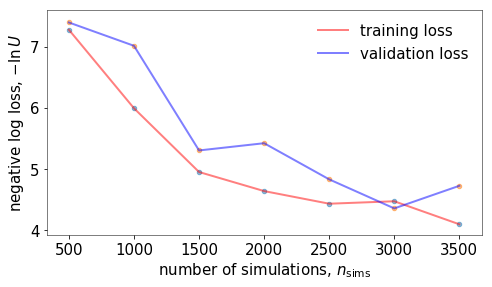

Population 7/23
Sampling proposal density...











Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...











Simulations:   0%|          | 1/499 [00:00<04:25,  1.87it/s]








Simulations:   0%|          | 2/499 [00:00<04:13,  1.96it/s]








Simulations:   1%|          | 3/499 [00:01<04:02,  2.04it/s]








Simulations:   1%|          | 4/499 [00:01<03:55,  2.10it/s]








Simulations:   1%|          | 5/499 [00:02<03:51,  2.13it/s]








Simulations:   1%|          | 6/499 [00:02<03:48,  2.16it/s]








Simulations:   1%|▏         | 7/499 [00:03<03:48,  2.15it/s]








Simulations:   2%|▏         | 8/499 [00:03<03:43,  2.20it/s]








Simulations:   2%|▏         | 9/499 [00:04<03:39,  2.24it/s]








Simulations:   2%|▏         | 10/499 [00:04<03:41,  2.21it/s]








Simulations:   2%|▏         | 11/499 [00:05<03:45,  2.17it/s]








Simulations:   2%|▏         | 12/499 [00:05<03:54,  2.08it/s]








Simulations:   3%|▎         | 13/499 [00:06<04:05,  1.98it/s]








Simulations:   3%|▎         | 14/499 [00:06<04:20,  1.86it/s]








Simulations:   3%|▎ 

Simulations:  34%|███▎      | 168/499 [01:24<02:45,  1.99it/s]








Simulations:  34%|███▍      | 169/499 [01:24<02:44,  2.01it/s]








Simulations:  34%|███▍      | 170/499 [01:25<02:42,  2.03it/s]








Simulations:  34%|███▍      | 171/499 [01:25<02:41,  2.03it/s]








Simulations:  34%|███▍      | 172/499 [01:26<02:39,  2.05it/s]








Simulations:  35%|███▍      | 173/499 [01:26<02:39,  2.04it/s]








Simulations:  35%|███▍      | 174/499 [01:27<02:46,  1.95it/s]








Simulations:  35%|███▌      | 175/499 [01:27<02:47,  1.94it/s]








Simulations:  35%|███▌      | 176/499 [01:28<02:43,  1.98it/s]








Simulations:  35%|███▌      | 177/499 [01:28<02:40,  2.01it/s]








Simulations:  36%|███▌      | 178/499 [01:29<02:40,  2.00it/s]








Simulations:  36%|███▌      | 179/499 [01:29<02:38,  2.02it/s]








Simulations:  36%|███▌      | 180/499 [01:30<02:37,  2.02it/s]








Simulations:  36%|███▋      | 181/499 [01:30<02:34,  2.05it/s]








Simula

Simulations:  67%|██████▋   | 334/499 [02:42<01:15,  2.17it/s]








Simulations:  67%|██████▋   | 335/499 [02:42<01:17,  2.12it/s]








Simulations:  67%|██████▋   | 336/499 [02:43<01:22,  1.98it/s]








Simulations:  68%|██████▊   | 337/499 [02:44<01:23,  1.95it/s]








Simulations:  68%|██████▊   | 338/499 [02:44<01:23,  1.93it/s]








Simulations:  68%|██████▊   | 339/499 [02:45<01:20,  1.99it/s]








Simulations:  68%|██████▊   | 340/499 [02:45<01:20,  1.99it/s]








Simulations:  68%|██████▊   | 341/499 [02:46<01:22,  1.91it/s]








Simulations:  69%|██████▊   | 342/499 [02:46<01:21,  1.93it/s]








Simulations:  69%|██████▊   | 343/499 [02:47<01:20,  1.93it/s]








Simulations:  69%|██████▉   | 344/499 [02:47<01:16,  2.03it/s]








Simulations:  69%|██████▉   | 345/499 [02:48<01:12,  2.11it/s]








Simulations:  69%|██████▉   | 346/499 [02:48<01:11,  2.14it/s]








Simulations:  70%|██████▉   | 347/499 [02:49<01:12,  2.09it/s]








Simula

Simulations: 500it [04:02,  1.92it/s]                         









Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Done.












Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=4.25, val_loss=4.36]









Epochs:   1%|          | 1/100 [00:00<00:42,  2.33it/s, train_loss=4.25, val_loss=4.36]









Epochs:   1%|          | 1/100 [00:00<00:42,  2.33it/s, train_loss=4.24, val_loss=4.36]









Epochs:   2%|▏         | 2/100 [00:00<00:40,  2.44it/s, train_loss=4.24, val_loss=4.36]









Epochs:   2%|▏         | 2/100 [00:00<00:40,  2.44it/s, train_loss=4.23, val_loss=4.34]









Epochs:   3%|▎         | 3/100 [00:01<00:38,  2.54it/s, train_loss=4.23, val_loss=4.34]









Epochs:   3%|▎         | 3/100 [00:01<00:38,  2.54it/s, train_loss=4.23, val_loss=4.37]









Epochs:   3%|▎         | 3/100 [00:01<00:38,  2.54it/s, train_loss=4.22, val_loss=4.35]









Epochs:   5%|▌         | 5/100 [00:01<00:28,  3.33it/s, train_loss=4.22, val_loss=4.35]









Epochs:   5%|▌         | 5/100 [00:01<00:28,  3.33it/s, train_loss=4.22, val_loss=4.37]









Epochs:   5%|▌         | 5/1

Training finished
Best epoch 00011, Val_loss: 4.3428
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model












Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_7.pdf


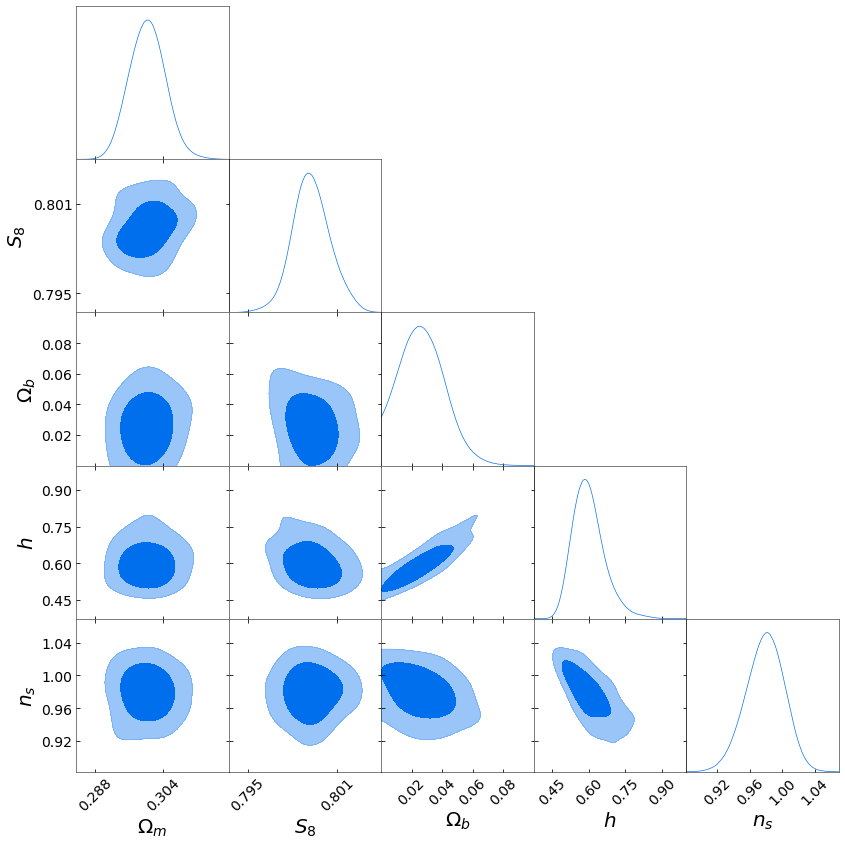

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


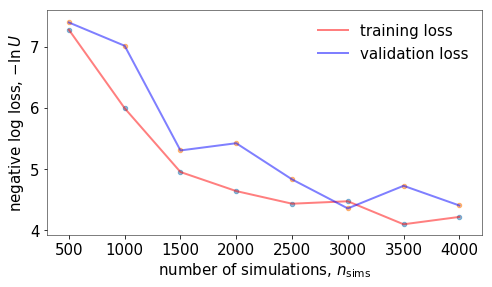

Population 8/23
Sampling proposal density...












Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...












Simulations:   0%|          | 1/499 [00:00<04:29,  1.85it/s]









Simulations:   0%|          | 2/499 [00:01<04:29,  1.85it/s]









Simulations:   1%|          | 3/499 [00:01<04:19,  1.91it/s]









Simulations:   1%|          | 4/499 [00:02<04:13,  1.96it/s]









Simulations:   1%|          | 5/499 [00:02<04:10,  1.97it/s]









Simulations:   1%|          | 6/499 [00:03<04:07,  1.99it/s]









Simulations:   1%|▏         | 7/499 [00:03<04:10,  1.97it/s]









Simulations:   2%|▏         | 8/499 [00:04<04:07,  1.99it/s]









Simulations:   2%|▏         | 9/499 [00:04<04:05,  1.99it/s]









Simulations:   2%|▏         | 10/499 [00:05<04:04,  2.00it/s]









Simulations:   2%|▏         | 11/499 [00:05<04:08,  1.97it/s]









Simulations:   2%|▏         | 12/499 [00:06<04:12,  1.93it/s]









Simulations:   3%|▎         | 13/499 [00:06<04:11,  1.93it/s]









Simulations:   3%|▎         | 14/499 [00:07<04:02,  2.00it/s]









Simul

Simulations:  32%|███▏      | 162/499 [01:20<02:32,  2.21it/s]









Simulations:  33%|███▎      | 163/499 [01:21<02:33,  2.20it/s]









Simulations:  33%|███▎      | 164/499 [01:21<02:43,  2.05it/s]









Simulations:  33%|███▎      | 165/499 [01:22<02:40,  2.09it/s]









Simulations:  33%|███▎      | 166/499 [01:22<02:49,  1.97it/s]









Simulations:  33%|███▎      | 167/499 [01:23<02:56,  1.88it/s]









Simulations:  34%|███▎      | 168/499 [01:24<02:49,  1.95it/s]









Simulations:  34%|███▍      | 169/499 [01:24<02:43,  2.02it/s]









Simulations:  34%|███▍      | 170/499 [01:24<02:39,  2.06it/s]









Simulations:  34%|███▍      | 171/499 [01:25<02:37,  2.09it/s]









Simulations:  34%|███▍      | 172/499 [01:25<02:46,  1.96it/s]









Simulations:  35%|███▍      | 173/499 [01:26<03:00,  1.81it/s]









Simulations:  35%|███▍      | 174/499 [01:27<03:08,  1.72it/s]









Simulations:  35%|███▌      | 175/499 [01:27<03:05,  1.75it/s]



Simulations:  65%|██████▍   | 322/499 [02:42<01:28,  2.01it/s]









Simulations:  65%|██████▍   | 323/499 [02:42<01:28,  1.98it/s]









Simulations:  65%|██████▍   | 324/499 [02:43<01:26,  2.03it/s]









Simulations:  65%|██████▌   | 325/499 [02:43<01:23,  2.10it/s]









Simulations:  65%|██████▌   | 326/499 [02:44<01:30,  1.91it/s]









Simulations:  66%|██████▌   | 327/499 [02:44<01:28,  1.94it/s]









Simulations:  66%|██████▌   | 328/499 [02:45<01:28,  1.94it/s]









Simulations:  66%|██████▌   | 329/499 [02:45<01:25,  1.98it/s]









Simulations:  66%|██████▌   | 330/499 [02:46<01:25,  1.97it/s]









Simulations:  66%|██████▋   | 331/499 [02:47<01:28,  1.91it/s]









Simulations:  67%|██████▋   | 332/499 [02:47<01:23,  2.01it/s]









Simulations:  67%|██████▋   | 333/499 [02:47<01:21,  2.05it/s]









Simulations:  67%|██████▋   | 334/499 [02:48<01:16,  2.15it/s]









Simulations:  67%|██████▋   | 335/499 [02:48<01:20,  2.05it/s]



Simulations:  97%|█████████▋| 482/499 [04:01<00:09,  1.77it/s]









Simulations:  97%|█████████▋| 483/499 [04:01<00:09,  1.71it/s]









Simulations:  97%|█████████▋| 484/499 [04:02<00:08,  1.74it/s]









Simulations:  97%|█████████▋| 485/499 [04:02<00:08,  1.67it/s]









Simulations:  97%|█████████▋| 486/499 [04:03<00:07,  1.71it/s]









Simulations:  98%|█████████▊| 487/499 [04:03<00:06,  1.81it/s]









Simulations:  98%|█████████▊| 488/499 [04:04<00:05,  1.89it/s]









Simulations:  98%|█████████▊| 489/499 [04:04<00:05,  1.95it/s]









Simulations:  98%|█████████▊| 490/499 [04:05<00:04,  2.01it/s]









Simulations:  98%|█████████▊| 491/499 [04:05<00:03,  2.05it/s]









Simulations:  99%|█████████▊| 492/499 [04:06<00:03,  2.09it/s]









Simulations:  99%|█████████▉| 493/499 [04:06<00:02,  2.13it/s]









Simulations:  99%|█████████▉| 494/499 [04:07<00:02,  2.07it/s]









Simulations:  99%|█████████▉| 495/499 [04:07<00:01,  2.05it/s]



Done.













Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=4.27, val_loss=4.38]










Epochs:   1%|          | 1/100 [00:00<00:54,  1.81it/s, train_loss=4.27, val_loss=4.38]










Epochs:   1%|          | 1/100 [00:00<00:54,  1.81it/s, train_loss=4.29, val_loss=4.38]










Epochs:   1%|          | 1/100 [00:00<00:54,  1.81it/s, train_loss=4.3, val_loss=4.44] 










Epochs:   3%|▎         | 3/100 [00:00<00:39,  2.43it/s, train_loss=4.3, val_loss=4.44]










Epochs:   3%|▎         | 3/100 [00:00<00:39,  2.43it/s, train_loss=4.28, val_loss=4.38]










Epochs:   3%|▎         | 3/100 [00:00<00:39,  2.43it/s, train_loss=4.25, val_loss=4.38]










Epochs:   5%|▌         | 5/100 [00:00<00:29,  3.22it/s, train_loss=4.25, val_loss=4.38]










Epochs:   5%|▌         | 5/100 [00:00<00:29,  3.22it/s, train_loss=4.23, val_loss=4.36]










Epochs:   6%|▌         | 6/100 [00:01<00:31,  2.99it/s, train_loss=4.23, val_loss=4.36]










Epochs:   6%|▌    

Training finished
Best epoch 00047, Val_loss: 4.2912
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...













Epochs:  47%|████▋     | 47/100 [00:22<00:05, 10.56it/s, train_loss=4.08, val_loss=4.4]

Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_8.pdf


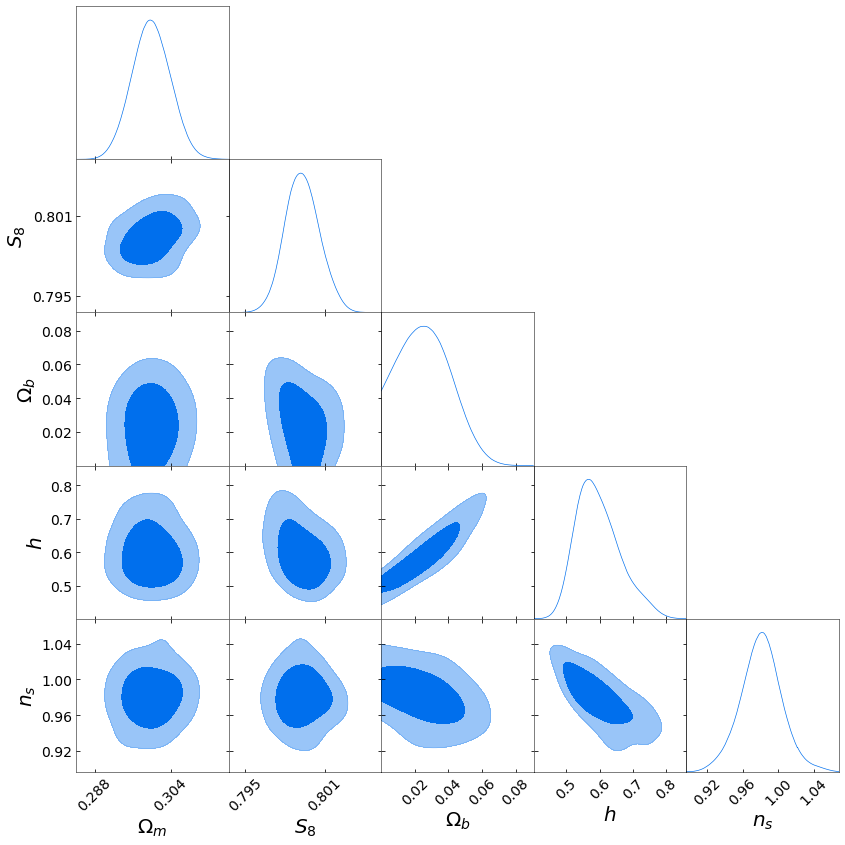

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


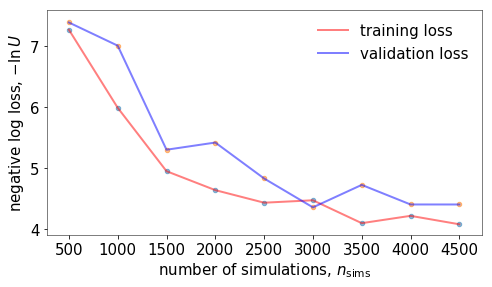

Population 9/23
Sampling proposal density...














Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...














Simulations:   0%|          | 1/499 [00:00<04:33,  1.82it/s]











Simulations:   0%|          | 2/499 [00:01<04:24,  1.88it/s]











Simulations:   1%|          | 3/499 [00:01<04:06,  2.01it/s]











Simulations:   1%|          | 4/499 [00:01<03:53,  2.12it/s]











Simulations:   1%|          | 5/499 [00:02<03:45,  2.19it/s]











Simulations:   1%|          | 6/499 [00:02<03:39,  2.25it/s]











Simulations:   1%|▏         | 7/499 [00:03<03:37,  2.26it/s]











Simulations:   2%|▏         | 8/499 [00:03<03:34,  2.29it/s]











Simulations:   2%|▏         | 9/499 [00:03<03:30,  2.32it/s]











Simulations:   2%|▏         | 10/499 [00:04<03:28,  2.35it/s]











Simulations:   2%|▏         | 11/499 [00:04<03:26,  2.37it/s]











Simulations:   2%|▏         | 12/499 [00:05<03:23,  2.39it/s]











Simulations:   3%|▎         | 13/499 [00:05<03:22,  2.40it/s]











Simulations:   3%|▎         | 14/499 [00:06<03:2

Simulations:  30%|███       | 150/499 [01:03<02:24,  2.41it/s]











Simulations:  30%|███       | 151/499 [01:03<02:23,  2.42it/s]











Simulations:  30%|███       | 152/499 [01:04<02:22,  2.43it/s]











Simulations:  31%|███       | 153/499 [01:04<02:22,  2.43it/s]











Simulations:  31%|███       | 154/499 [01:05<02:21,  2.44it/s]











Simulations:  31%|███       | 155/499 [01:05<02:21,  2.44it/s]











Simulations:  31%|███▏      | 156/499 [01:05<02:20,  2.44it/s]











Simulations:  31%|███▏      | 157/499 [01:06<02:20,  2.44it/s]











Simulations:  32%|███▏      | 158/499 [01:06<02:19,  2.44it/s]











Simulations:  32%|███▏      | 159/499 [01:07<02:20,  2.42it/s]











Simulations:  32%|███▏      | 160/499 [01:07<02:19,  2.43it/s]











Simulations:  32%|███▏      | 161/499 [01:07<02:18,  2.43it/s]











Simulations:  32%|███▏      | 162/499 [01:08<02:17,  2.45it/s]











Simulations:  33%|███▎      | 163/499 

Simulations:  60%|█████▉    | 298/499 [02:04<01:20,  2.48it/s]











Simulations:  60%|█████▉    | 299/499 [02:05<01:21,  2.47it/s]











Simulations:  60%|██████    | 300/499 [02:05<01:21,  2.44it/s]











Simulations:  60%|██████    | 301/499 [02:05<01:20,  2.45it/s]











Simulations:  61%|██████    | 302/499 [02:06<01:20,  2.46it/s]











Simulations:  61%|██████    | 303/499 [02:06<01:19,  2.46it/s]











Simulations:  61%|██████    | 304/499 [02:07<01:19,  2.46it/s]











Simulations:  61%|██████    | 305/499 [02:07<01:19,  2.45it/s]











Simulations:  61%|██████▏   | 306/499 [02:08<01:18,  2.46it/s]











Simulations:  62%|██████▏   | 307/499 [02:08<01:18,  2.44it/s]











Simulations:  62%|██████▏   | 308/499 [02:08<01:18,  2.44it/s]











Simulations:  62%|██████▏   | 309/499 [02:09<01:18,  2.43it/s]











Simulations:  62%|██████▏   | 310/499 [02:09<01:18,  2.40it/s]











Simulations:  62%|██████▏   | 311/499 

Simulations:  89%|████████▉ | 446/499 [03:05<00:22,  2.38it/s]











Simulations:  90%|████████▉ | 447/499 [03:06<00:21,  2.39it/s]











Simulations:  90%|████████▉ | 448/499 [03:06<00:21,  2.42it/s]











Simulations:  90%|████████▉ | 449/499 [03:06<00:20,  2.44it/s]











Simulations:  90%|█████████ | 450/499 [03:07<00:19,  2.47it/s]











Simulations:  90%|█████████ | 451/499 [03:07<00:19,  2.49it/s]











Simulations:  91%|█████████ | 452/499 [03:08<00:18,  2.49it/s]











Simulations:  91%|█████████ | 453/499 [03:08<00:18,  2.51it/s]











Simulations:  91%|█████████ | 454/499 [03:08<00:17,  2.52it/s]











Simulations:  91%|█████████ | 455/499 [03:09<00:17,  2.53it/s]











Simulations:  91%|█████████▏| 456/499 [03:09<00:16,  2.53it/s]











Simulations:  92%|█████████▏| 457/499 [03:10<00:16,  2.53it/s]











Simulations:  92%|█████████▏| 458/499 [03:10<00:16,  2.53it/s]











Simulations:  92%|█████████▏| 459/499 

Done.















Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=4.07, val_loss=4.24]












Epochs:   1%|          | 1/100 [00:00<01:16,  1.29it/s, train_loss=4.07, val_loss=4.24]












Epochs:   1%|          | 1/100 [00:00<01:16,  1.29it/s, train_loss=4.06, val_loss=4.24]












Epochs:   2%|▏         | 2/100 [00:01<01:04,  1.52it/s, train_loss=4.06, val_loss=4.24]












Epochs:   2%|▏         | 2/100 [00:01<01:04,  1.52it/s, train_loss=4.05, val_loss=4.24]












Epochs:   3%|▎         | 3/100 [00:01<00:57,  1.69it/s, train_loss=4.05, val_loss=4.24]












Epochs:   3%|▎         | 3/100 [00:01<00:57,  1.69it/s, train_loss=4.05, val_loss=4.24]












Epochs:   3%|▎         | 3/100 [00:01<00:57,  1.69it/s, train_loss=4.06, val_loss=4.28]












Epochs:   5%|▌         | 5/100 [00:01<00:41,  2.29it/s, train_loss=4.06, val_loss=4.28]












Epochs:   5%|▌         | 5/100 [00:01<00:41,  2.29it/s, train_loss=4.03, val_loss=4.24]









Training finished
Best epoch 00022, Val_loss: 4.2321
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...















Epochs:  22%|██▏       | 22/100 [00:13<00:07,  9.90it/s, train_loss=3.98, val_loss=4.27]

Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_9.pdf


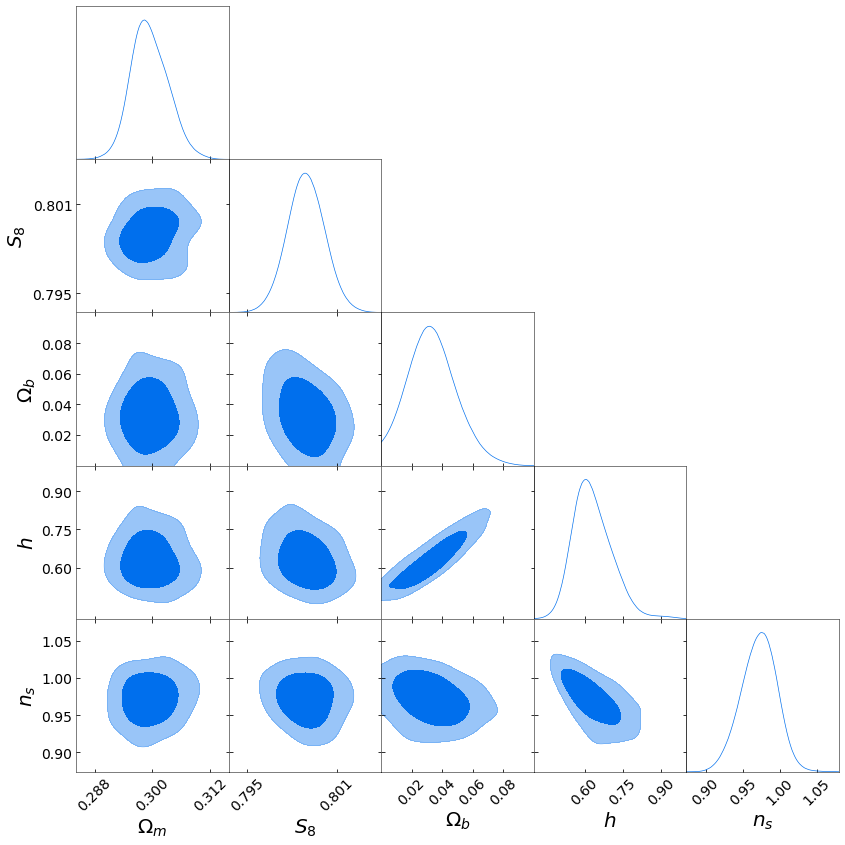

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


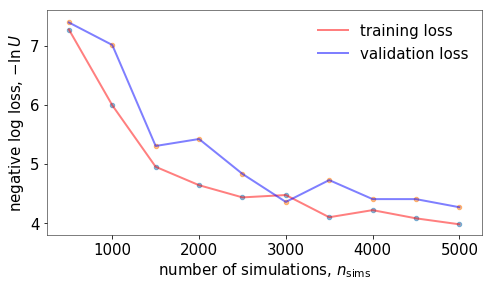

Population 10/23
Sampling proposal density...
















Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...
















Simulations:   0%|          | 1/499 [00:00<03:34,  2.32it/s]













Simulations:   0%|          | 2/499 [00:00<03:36,  2.30it/s]













Simulations:   1%|          | 3/499 [00:01<03:37,  2.28it/s]













Simulations:   1%|          | 4/499 [00:01<03:36,  2.29it/s]













Simulations:   1%|          | 5/499 [00:02<03:36,  2.28it/s]













Simulations:   1%|          | 6/499 [00:02<03:35,  2.29it/s]













Simulations:   1%|▏         | 7/499 [00:03<03:33,  2.31it/s]













Simulations:   2%|▏         | 8/499 [00:03<03:30,  2.34it/s]













Simulations:   2%|▏         | 9/499 [00:03<03:29,  2.34it/s]













Simulations:   2%|▏         | 10/499 [00:04<03:29,  2.33it/s]













Simulations:   2%|▏         | 11/499 [00:04<03:30,  2.32it/s]













Simulations:   2%|▏         | 12/499 [00:05<03:29,  2.32it/s]













Simulations:   3%|▎         | 13/499 [00:05<03:28,  2.33it/s]













Simulations:   3%|▎ 

Simulations:  14%|█▍        | 71/499 [00:31<03:06,  2.29it/s]













Simulations:  14%|█▍        | 72/499 [00:31<03:06,  2.29it/s]













Simulations:  15%|█▍        | 73/499 [00:32<03:06,  2.29it/s]













Simulations:  15%|█▍        | 74/499 [00:32<03:05,  2.29it/s]













Simulations:  15%|█▌        | 75/499 [00:33<03:04,  2.29it/s]













Simulations:  15%|█▌        | 76/499 [00:33<03:04,  2.29it/s]













Simulations:  15%|█▌        | 77/499 [00:34<03:04,  2.29it/s]













Simulations:  16%|█▌        | 78/499 [00:34<03:04,  2.28it/s]













Simulations:  16%|█▌        | 79/499 [00:34<03:04,  2.28it/s]













Simulations:  16%|█▌        | 80/499 [00:35<03:04,  2.27it/s]













Simulations:  16%|█▌        | 81/499 [00:35<03:04,  2.27it/s]













Simulations:  16%|█▋        | 82/499 [00:36<03:04,  2.26it/s]













Simulations:  17%|█▋        | 83/499 [00:36<03:04,  2.25it/s]













Simulations:  17%|█▋     

Simulations:  42%|████▏     | 209/499 [01:29<02:06,  2.28it/s]













Simulations:  42%|████▏     | 210/499 [01:30<02:03,  2.33it/s]













Simulations:  42%|████▏     | 211/499 [01:30<02:01,  2.37it/s]













Simulations:  42%|████▏     | 212/499 [01:31<02:00,  2.38it/s]













Simulations:  43%|████▎     | 213/499 [01:31<01:59,  2.40it/s]













Simulations:  43%|████▎     | 214/499 [01:31<02:00,  2.36it/s]













Simulations:  43%|████▎     | 215/499 [01:32<02:01,  2.34it/s]













Simulations:  43%|████▎     | 216/499 [01:32<02:01,  2.33it/s]













Simulations:  43%|████▎     | 217/499 [01:33<01:58,  2.37it/s]













Simulations:  44%|████▎     | 218/499 [01:33<01:57,  2.40it/s]













Simulations:  44%|████▍     | 219/499 [01:34<01:55,  2.43it/s]













Simulations:  44%|████▍     | 220/499 [01:34<01:54,  2.44it/s]













Simulations:  44%|████▍     | 221/499 [01:34<01:52,  2.46it/s]













Simulations:

Simulations:  70%|██████▉   | 347/499 [02:25<01:06,  2.30it/s]













Simulations:  70%|██████▉   | 348/499 [02:26<01:05,  2.29it/s]













Simulations:  70%|██████▉   | 349/499 [02:26<01:05,  2.29it/s]













Simulations:  70%|███████   | 350/499 [02:27<01:05,  2.27it/s]













Simulations:  70%|███████   | 351/499 [02:27<01:05,  2.25it/s]













Simulations:  71%|███████   | 352/499 [02:27<01:06,  2.22it/s]













Simulations:  71%|███████   | 353/499 [02:28<01:04,  2.27it/s]













Simulations:  71%|███████   | 354/499 [02:28<01:02,  2.32it/s]













Simulations:  71%|███████   | 355/499 [02:29<01:01,  2.36it/s]













Simulations:  71%|███████▏  | 356/499 [02:29<00:59,  2.38it/s]













Simulations:  72%|███████▏  | 357/499 [02:30<00:59,  2.40it/s]













Simulations:  72%|███████▏  | 358/499 [02:30<00:58,  2.41it/s]













Simulations:  72%|███████▏  | 359/499 [02:30<00:57,  2.42it/s]













Simulations:

Simulations:  97%|█████████▋| 485/499 [03:23<00:05,  2.45it/s]













Simulations:  97%|█████████▋| 486/499 [03:24<00:05,  2.45it/s]













Simulations:  98%|█████████▊| 487/499 [03:24<00:04,  2.45it/s]













Simulations:  98%|█████████▊| 488/499 [03:24<00:04,  2.43it/s]













Simulations:  98%|█████████▊| 489/499 [03:25<00:04,  2.44it/s]













Simulations:  98%|█████████▊| 490/499 [03:25<00:03,  2.45it/s]













Simulations:  98%|█████████▊| 491/499 [03:26<00:03,  2.46it/s]













Simulations:  99%|█████████▊| 492/499 [03:26<00:02,  2.46it/s]













Simulations:  99%|█████████▉| 493/499 [03:26<00:02,  2.46it/s]













Simulations:  99%|█████████▉| 494/499 [03:27<00:02,  2.47it/s]













Simulations:  99%|█████████▉| 495/499 [03:27<00:01,  2.48it/s]













Simulations:  99%|█████████▉| 496/499 [03:28<00:01,  2.47it/s]













Simulations: 100%|█████████▉| 497/499 [03:28<00:00,  2.47it/s]













Simulations:

Done.

















Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=4.18, val_loss=4.27]














Epochs:   1%|          | 1/100 [00:00<00:50,  1.96it/s, train_loss=4.18, val_loss=4.27]














Epochs:   1%|          | 1/100 [00:00<00:50,  1.96it/s, train_loss=4.15, val_loss=4.23]














Epochs:   2%|▏         | 2/100 [00:00<00:45,  2.15it/s, train_loss=4.15, val_loss=4.23]














Epochs:   2%|▏         | 2/100 [00:00<00:45,  2.15it/s, train_loss=4.14, val_loss=4.21]














Epochs:   3%|▎         | 3/100 [00:01<00:41,  2.35it/s, train_loss=4.14, val_loss=4.21]














Epochs:   3%|▎         | 3/100 [00:01<00:41,  2.35it/s, train_loss=4.13, val_loss=4.2] 














Epochs:   4%|▍         | 4/100 [00:01<00:40,  2.35it/s, train_loss=4.13, val_loss=4.2]














Epochs:   4%|▍         | 4/100 [00:01<00:40,  2.35it/s, train_loss=4.15, val_loss=4.23]














Epochs:   4%|▍         | 4/100 [00:01<00:40,  2.35it/s, train_loss=4.12, val

Training finished
Best epoch 00035, Val_loss: 4.1146
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model

















Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_10.pdf


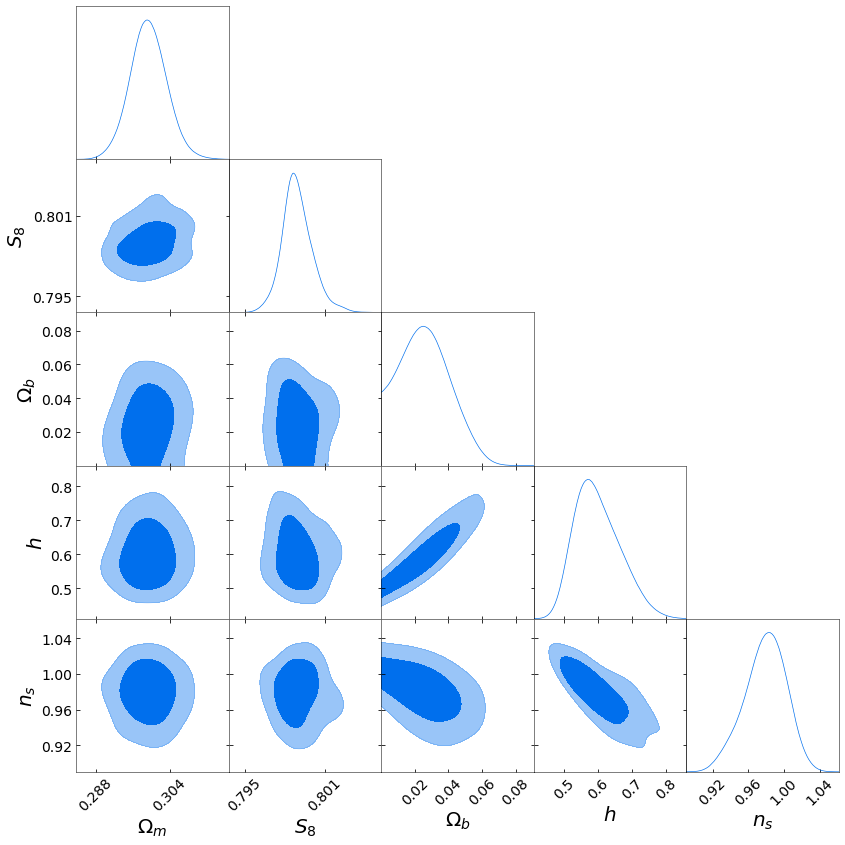

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


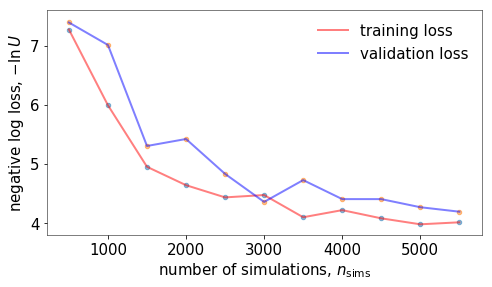

Population 11/23
Sampling proposal density...

















Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...

















Simulations:   0%|          | 1/499 [00:00<04:27,  1.87it/s]














Simulations:   0%|          | 2/499 [00:01<04:16,  1.93it/s]














Simulations:   1%|          | 3/499 [00:01<03:58,  2.08it/s]














Simulations:   1%|          | 4/499 [00:01<03:45,  2.20it/s]














Simulations:   1%|          | 5/499 [00:02<03:36,  2.29it/s]














Simulations:   1%|          | 6/499 [00:02<03:29,  2.35it/s]














Simulations:   1%|▏         | 7/499 [00:02<03:25,  2.40it/s]














Simulations:   2%|▏         | 8/499 [00:03<03:21,  2.43it/s]














Simulations:   2%|▏         | 9/499 [00:03<03:19,  2.46it/s]














Simulations:   2%|▏         | 10/499 [00:04<03:16,  2.49it/s]














Simulations:   2%|▏         | 11/499 [00:04<03:15,  2.49it/s]














Simulations:   2%|▏         | 12/499 [00:04<03:14,  2.50it/s]














Simulations:   3%|▎         | 13/499 [00:05<03:14,  2.50it/s]














Simula

Simulations:  27%|██▋       | 135/499 [00:55<02:29,  2.44it/s]














Simulations:  27%|██▋       | 136/499 [00:55<02:28,  2.44it/s]














Simulations:  27%|██▋       | 137/499 [00:56<02:29,  2.42it/s]














Simulations:  28%|██▊       | 138/499 [00:56<02:29,  2.41it/s]














Simulations:  28%|██▊       | 139/499 [00:57<02:29,  2.41it/s]














Simulations:  28%|██▊       | 140/499 [00:57<02:28,  2.42it/s]














Simulations:  28%|██▊       | 141/499 [00:57<02:27,  2.43it/s]














Simulations:  28%|██▊       | 142/499 [00:58<02:27,  2.43it/s]














Simulations:  29%|██▊       | 143/499 [00:58<02:39,  2.23it/s]














Simulations:  29%|██▉       | 144/499 [00:59<02:48,  2.11it/s]














Simulations:  29%|██▉       | 145/499 [00:59<02:43,  2.16it/s]














Simulations:  29%|██▉       | 146/499 [01:00<02:37,  2.24it/s]














Simulations:  29%|██▉       | 147/499 [01:00<02:36,  2.25it/s]















Simulations:  54%|█████▍    | 269/499 [01:50<01:30,  2.55it/s]














Simulations:  54%|█████▍    | 270/499 [01:51<01:28,  2.58it/s]














Simulations:  54%|█████▍    | 271/499 [01:51<01:28,  2.58it/s]














Simulations:  55%|█████▍    | 272/499 [01:52<01:27,  2.59it/s]














Simulations:  55%|█████▍    | 273/499 [01:52<01:27,  2.60it/s]














Simulations:  55%|█████▍    | 274/499 [01:52<01:26,  2.60it/s]














Simulations:  55%|█████▌    | 275/499 [01:53<01:25,  2.61it/s]














Simulations:  55%|█████▌    | 276/499 [01:53<01:25,  2.62it/s]














Simulations:  56%|█████▌    | 277/499 [01:54<01:25,  2.61it/s]














Simulations:  56%|█████▌    | 278/499 [01:54<01:24,  2.61it/s]














Simulations:  56%|█████▌    | 279/499 [01:54<01:24,  2.62it/s]














Simulations:  56%|█████▌    | 280/499 [01:55<01:24,  2.58it/s]














Simulations:  56%|█████▋    | 281/499 [01:55<01:25,  2.56it/s]















Simulations:  81%|████████  | 403/499 [02:44<00:38,  2.49it/s]














Simulations:  81%|████████  | 404/499 [02:44<00:38,  2.48it/s]














Simulations:  81%|████████  | 405/499 [02:45<00:37,  2.48it/s]














Simulations:  81%|████████▏ | 406/499 [02:45<00:37,  2.49it/s]














Simulations:  82%|████████▏ | 407/499 [02:45<00:36,  2.49it/s]














Simulations:  82%|████████▏ | 408/499 [02:46<00:36,  2.50it/s]














Simulations:  82%|████████▏ | 409/499 [02:46<00:35,  2.50it/s]














Simulations:  82%|████████▏ | 410/499 [02:47<00:35,  2.50it/s]














Simulations:  82%|████████▏ | 411/499 [02:47<00:35,  2.50it/s]














Simulations:  83%|████████▎ | 412/499 [02:47<00:34,  2.51it/s]














Simulations:  83%|████████▎ | 413/499 [02:48<00:34,  2.51it/s]














Simulations:  83%|████████▎ | 414/499 [02:48<00:33,  2.50it/s]














Simulations:  83%|████████▎ | 415/499 [02:49<00:33,  2.51it/s]















Done.


















Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=4.01, val_loss=4.17]















Epochs:   1%|          | 1/100 [00:00<00:47,  2.10it/s, train_loss=4.01, val_loss=4.17]















Epochs:   1%|          | 1/100 [00:00<00:47,  2.10it/s, train_loss=4.03, val_loss=4.19]















Epochs:   1%|          | 1/100 [00:00<00:47,  2.10it/s, train_loss=3.99, val_loss=4.17]















Epochs:   3%|▎         | 3/100 [00:00<00:39,  2.46it/s, train_loss=3.99, val_loss=4.17]















Epochs:   3%|▎         | 3/100 [00:01<00:39,  2.46it/s, train_loss=3.99, val_loss=4.17]















Epochs:   3%|▎         | 3/100 [00:01<00:39,  2.46it/s, train_loss=4, val_loss=4.2]    















Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.25it/s, train_loss=4, val_loss=4.2]















Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.25it/s, train_loss=3.98, val_loss=4.18]















Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.25it/s, train_loss=3.

Training finished
Best epoch 00011, Val_loss: 4.1658
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


















Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_11.pdf


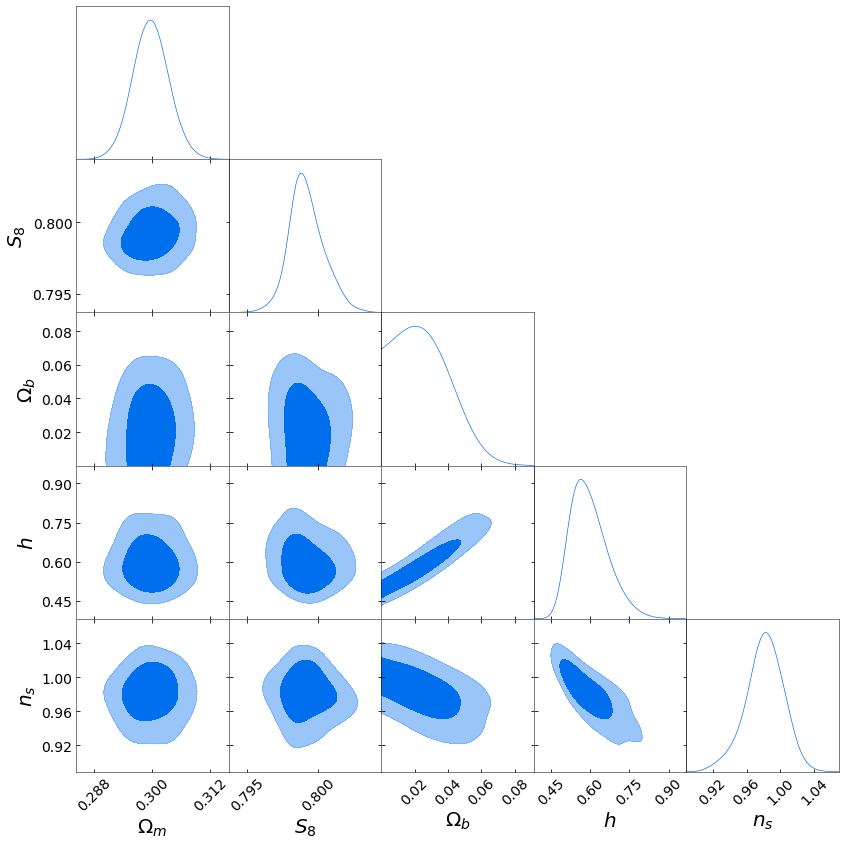

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


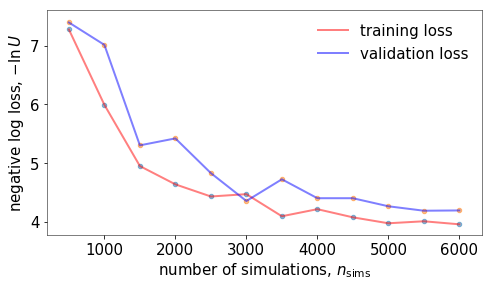

Population 12/23
Sampling proposal density...


















Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...


















Simulations:   0%|          | 1/499 [00:00<04:33,  1.82it/s]















Simulations:   0%|          | 2/499 [00:01<04:25,  1.88it/s]















Simulations:   1%|          | 3/499 [00:01<04:05,  2.02it/s]















Simulations:   1%|          | 4/499 [00:01<03:51,  2.14it/s]















Simulations:   1%|          | 5/499 [00:02<03:42,  2.22it/s]















Simulations:   1%|          | 6/499 [00:02<03:34,  2.30it/s]















Simulations:   1%|▏         | 7/499 [00:03<03:28,  2.36it/s]















Simulations:   2%|▏         | 8/499 [00:03<03:24,  2.40it/s]















Simulations:   2%|▏         | 9/499 [00:03<03:22,  2.42it/s]















Simulations:   2%|▏         | 10/499 [00:04<03:21,  2.43it/s]















Simulations:   2%|▏         | 11/499 [00:04<03:20,  2.44it/s]















Simulations:   2%|▏         | 12/499 [00:05<03:18,  2.46it/s]















Simulations:   3%|▎         | 13/499 [00:05<03:17,  2.46it/s]









Simulations:  26%|██▋       | 131/499 [00:53<02:35,  2.36it/s]















Simulations:  26%|██▋       | 132/499 [00:53<02:36,  2.34it/s]















Simulations:  27%|██▋       | 133/499 [00:54<02:36,  2.34it/s]















Simulations:  27%|██▋       | 134/499 [00:54<02:34,  2.36it/s]















Simulations:  27%|██▋       | 135/499 [00:55<02:34,  2.36it/s]















Simulations:  27%|██▋       | 136/499 [00:55<02:34,  2.35it/s]















Simulations:  27%|██▋       | 137/499 [00:56<02:38,  2.28it/s]















Simulations:  28%|██▊       | 138/499 [00:56<02:36,  2.31it/s]















Simulations:  28%|██▊       | 139/499 [00:56<02:31,  2.37it/s]















Simulations:  28%|██▊       | 140/499 [00:57<02:29,  2.41it/s]















Simulations:  28%|██▊       | 141/499 [00:57<02:27,  2.43it/s]















Simulations:  28%|██▊       | 142/499 [00:58<02:25,  2.45it/s]















Simulations:  29%|██▊       | 143/499 [00:58<02:23,  2.48it/s]



Simulations:  52%|█████▏    | 261/499 [01:47<01:36,  2.46it/s]















Simulations:  53%|█████▎    | 262/499 [01:48<01:36,  2.46it/s]















Simulations:  53%|█████▎    | 263/499 [01:48<01:33,  2.51it/s]















Simulations:  53%|█████▎    | 264/499 [01:48<01:33,  2.52it/s]















Simulations:  53%|█████▎    | 265/499 [01:49<01:33,  2.51it/s]















Simulations:  53%|█████▎    | 266/499 [01:49<01:31,  2.54it/s]















Simulations:  54%|█████▎    | 267/499 [01:50<01:30,  2.56it/s]















Simulations:  54%|█████▎    | 268/499 [01:50<01:31,  2.52it/s]















Simulations:  54%|█████▍    | 269/499 [01:50<01:30,  2.55it/s]















Simulations:  54%|█████▍    | 270/499 [01:51<01:29,  2.57it/s]















Simulations:  54%|█████▍    | 271/499 [01:51<01:28,  2.59it/s]















Simulations:  55%|█████▍    | 272/499 [01:51<01:28,  2.56it/s]















Simulations:  55%|█████▍    | 273/499 [01:52<01:28,  2.55it/s]



Simulations:  78%|███████▊  | 391/499 [02:43<00:43,  2.46it/s]















Simulations:  79%|███████▊  | 392/499 [02:43<00:43,  2.48it/s]















Simulations:  79%|███████▉  | 393/499 [02:44<00:42,  2.50it/s]















Simulations:  79%|███████▉  | 394/499 [02:44<00:42,  2.49it/s]















Simulations:  79%|███████▉  | 395/499 [02:44<00:42,  2.44it/s]















Simulations:  79%|███████▉  | 396/499 [02:45<00:42,  2.45it/s]















Simulations:  80%|███████▉  | 397/499 [02:45<00:41,  2.47it/s]















Simulations:  80%|███████▉  | 398/499 [02:46<00:40,  2.48it/s]















Simulations:  80%|███████▉  | 399/499 [02:46<00:40,  2.47it/s]















Simulations:  80%|████████  | 400/499 [02:47<00:40,  2.47it/s]















Simulations:  80%|████████  | 401/499 [02:47<00:38,  2.51it/s]















Simulations:  81%|████████  | 402/499 [02:47<00:38,  2.54it/s]















Simulations:  81%|████████  | 403/499 [02:48<00:37,  2.56it/s]



Done.



















Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=4, val_loss=4.1]
















Epochs:   1%|          | 1/100 [00:00<00:51,  1.93it/s, train_loss=4, val_loss=4.1]
















Epochs:   1%|          | 1/100 [00:00<00:51,  1.93it/s, train_loss=3.99, val_loss=4.11]
















Epochs:   1%|          | 1/100 [00:00<00:51,  1.93it/s, train_loss=3.97, val_loss=4.1] 
















Epochs:   3%|▎         | 3/100 [00:00<00:37,  2.58it/s, train_loss=3.97, val_loss=4.1]
















Epochs:   3%|▎         | 3/100 [00:00<00:37,  2.58it/s, train_loss=3.97, val_loss=4.09]
















Epochs:   4%|▍         | 4/100 [00:01<00:39,  2.40it/s, train_loss=3.97, val_loss=4.09]
















Epochs:   4%|▍         | 4/100 [00:01<00:39,  2.40it/s, train_loss=3.97, val_loss=4.13]
















Epochs:   4%|▍         | 4/100 [00:01<00:39,  2.40it/s, train_loss=3.99, val_loss=4.13]
















Epochs:   6%|▌         | 6/100 [00:01<00:29,  3.18it/s, train_lo

Training finished
Best epoch 00012, Val_loss: 4.0940
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model



















Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_12.pdf


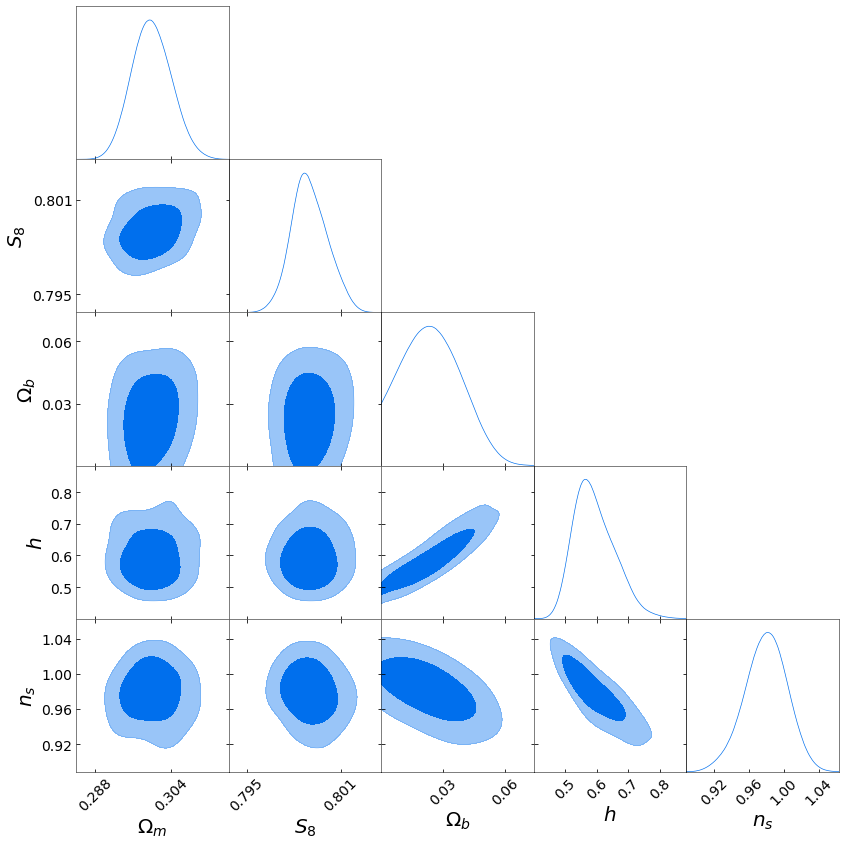

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


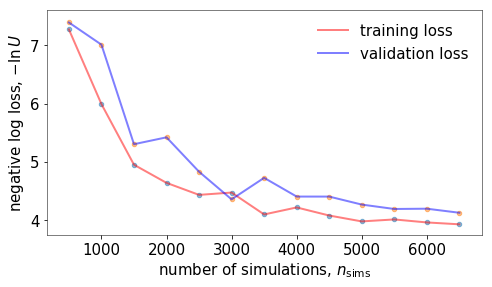

Population 13/23
Sampling proposal density...



















Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...



















Simulations:   0%|          | 1/499 [00:00<04:30,  1.84it/s]
















Simulations:   0%|          | 2/499 [00:01<04:23,  1.89it/s]
















Simulations:   1%|          | 3/499 [00:01<04:02,  2.04it/s]
















Simulations:   1%|          | 4/499 [00:01<03:49,  2.15it/s]
















Simulations:   1%|          | 5/499 [00:02<03:39,  2.25it/s]
















Simulations:   1%|          | 6/499 [00:02<03:32,  2.32it/s]
















Simulations:   1%|▏         | 7/499 [00:03<03:27,  2.37it/s]
















Simulations:   2%|▏         | 8/499 [00:03<03:24,  2.41it/s]
















Simulations:   2%|▏         | 9/499 [00:03<03:21,  2.43it/s]
















Simulations:   2%|▏         | 10/499 [00:04<03:21,  2.43it/s]
















Simulations:   2%|▏         | 11/499 [00:04<03:22,  2.41it/s]
















Simulations:   2%|▏         | 12/499 [00:05<03:21,  2.41it/s]
















Simulations:   3%|▎         | 13/499 [00:05<03:21,  2.41

Simulations:  25%|██▌       | 127/499 [00:52<02:30,  2.47it/s]
















Simulations:  26%|██▌       | 128/499 [00:53<02:29,  2.47it/s]
















Simulations:  26%|██▌       | 129/499 [00:53<02:29,  2.47it/s]
















Simulations:  26%|██▌       | 130/499 [00:54<02:30,  2.46it/s]
















Simulations:  26%|██▋       | 131/499 [00:54<02:29,  2.47it/s]
















Simulations:  26%|██▋       | 132/499 [00:54<02:28,  2.48it/s]
















Simulations:  27%|██▋       | 133/499 [00:55<02:44,  2.22it/s]
















Simulations:  27%|██▋       | 134/499 [00:55<02:39,  2.29it/s]
















Simulations:  27%|██▋       | 135/499 [00:56<02:35,  2.35it/s]
















Simulations:  27%|██▋       | 136/499 [00:56<02:31,  2.39it/s]
















Simulations:  27%|██▋       | 137/499 [00:57<02:30,  2.41it/s]
















Simulations:  28%|██▊       | 138/499 [00:57<02:29,  2.42it/s]
















Simulations:  28%|██▊       | 139/499 [00:57<02:26, 

Simulations:  51%|█████     | 253/499 [01:44<01:51,  2.20it/s]
















Simulations:  51%|█████     | 254/499 [01:44<01:53,  2.15it/s]
















Simulations:  51%|█████     | 255/499 [01:45<01:51,  2.18it/s]
















Simulations:  51%|█████▏    | 256/499 [01:45<01:48,  2.23it/s]
















Simulations:  52%|█████▏    | 257/499 [01:46<01:49,  2.22it/s]
















Simulations:  52%|█████▏    | 258/499 [01:46<01:49,  2.21it/s]
















Simulations:  52%|█████▏    | 259/499 [01:47<01:49,  2.20it/s]
















Simulations:  52%|█████▏    | 260/499 [01:47<01:48,  2.21it/s]
















Simulations:  52%|█████▏    | 261/499 [01:47<01:46,  2.23it/s]
















Simulations:  53%|█████▎    | 262/499 [01:48<01:45,  2.24it/s]
















Simulations:  53%|█████▎    | 263/499 [01:48<01:42,  2.30it/s]
















Simulations:  53%|█████▎    | 264/499 [01:49<01:39,  2.35it/s]
















Simulations:  53%|█████▎    | 265/499 [01:49<01:37, 

Simulations:  76%|███████▌  | 379/499 [02:37<00:48,  2.49it/s]
















Simulations:  76%|███████▌  | 380/499 [02:37<00:48,  2.47it/s]
















Simulations:  76%|███████▋  | 381/499 [02:38<00:47,  2.46it/s]
















Simulations:  77%|███████▋  | 382/499 [02:38<00:47,  2.45it/s]
















Simulations:  77%|███████▋  | 383/499 [02:39<00:47,  2.46it/s]
















Simulations:  77%|███████▋  | 384/499 [02:39<00:46,  2.47it/s]
















Simulations:  77%|███████▋  | 385/499 [02:39<00:46,  2.46it/s]
















Simulations:  77%|███████▋  | 386/499 [02:40<00:46,  2.44it/s]
















Simulations:  78%|███████▊  | 387/499 [02:40<00:45,  2.46it/s]
















Simulations:  78%|███████▊  | 388/499 [02:41<00:44,  2.49it/s]
















Simulations:  78%|███████▊  | 389/499 [02:41<00:44,  2.50it/s]
















Simulations:  78%|███████▊  | 390/499 [02:42<00:44,  2.42it/s]
















Simulations:  78%|███████▊  | 391/499 [02:42<00:45, 

Done.




















Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=4, val_loss=4.08]

















Epochs:   1%|          | 1/100 [00:00<01:00,  1.63it/s, train_loss=4, val_loss=4.08]

















Epochs:   1%|          | 1/100 [00:00<01:00,  1.63it/s, train_loss=3.98, val_loss=4.09]

















Epochs:   1%|          | 1/100 [00:00<01:00,  1.63it/s, train_loss=3.99, val_loss=4.09]

















Epochs:   3%|▎         | 3/100 [00:00<00:44,  2.20it/s, train_loss=3.99, val_loss=4.09]

















Epochs:   3%|▎         | 3/100 [00:00<00:44,  2.20it/s, train_loss=3.98, val_loss=4.09]

















Epochs:   3%|▎         | 3/100 [00:00<00:44,  2.20it/s, train_loss=3.97, val_loss=4.1] 

















Epochs:   5%|▌         | 5/100 [00:00<00:32,  2.94it/s, train_loss=3.97, val_loss=4.1]

















Epochs:   5%|▌         | 5/100 [00:01<00:32,  2.94it/s, train_loss=4.01, val_loss=4.14]

















Epochs:   5%|▌         | 5/100 [00:01<00:32,  2.94it

Training finished
Best epoch 00009, Val_loss: 4.0795
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model




















Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_13.pdf


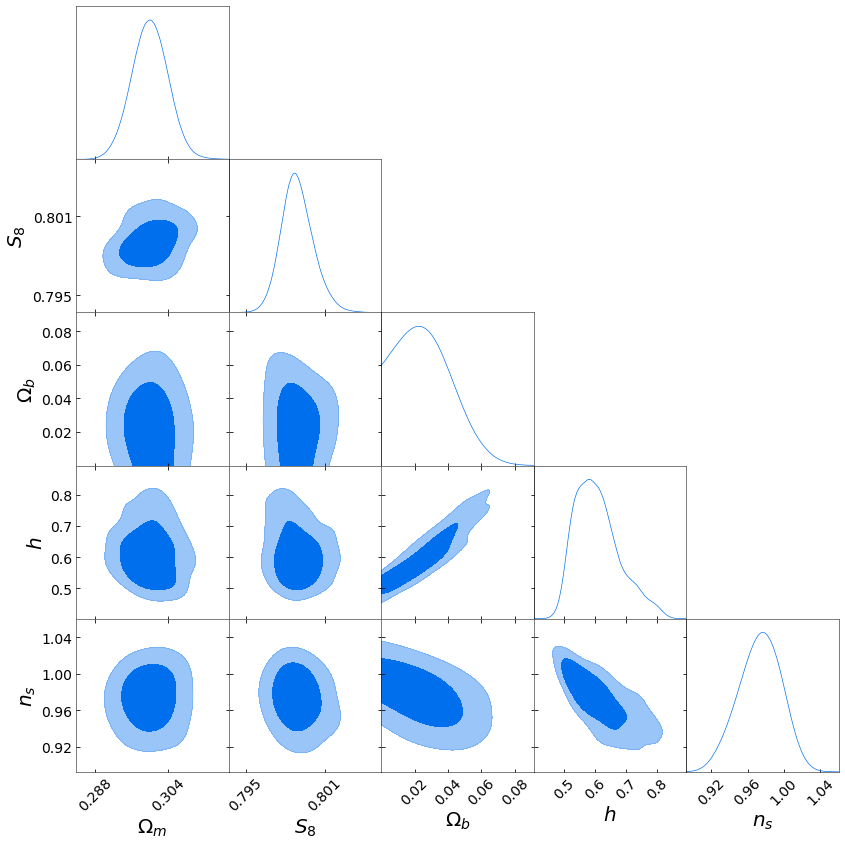

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


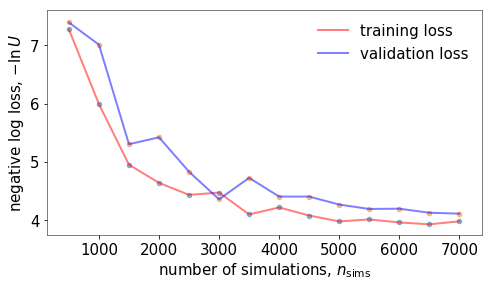

Population 14/23
Sampling proposal density...




















Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...




















Simulations:   0%|          | 1/499 [00:00<03:24,  2.44it/s]

















Simulations:   0%|          | 2/499 [00:00<03:24,  2.43it/s]

















Simulations:   1%|          | 3/499 [00:01<03:23,  2.44it/s]

















Simulations:   1%|          | 4/499 [00:01<03:20,  2.47it/s]

















Simulations:   1%|          | 5/499 [00:02<03:18,  2.49it/s]

















Simulations:   1%|          | 6/499 [00:02<03:17,  2.50it/s]

















Simulations:   1%|▏         | 7/499 [00:02<03:16,  2.50it/s]

















Simulations:   2%|▏         | 8/499 [00:03<03:15,  2.51it/s]

















Simulations:   2%|▏         | 9/499 [00:03<03:14,  2.51it/s]

















Simulations:   2%|▏         | 10/499 [00:04<03:15,  2.51it/s]

















Simulations:   2%|▏         | 11/499 [00:04<03:13,  2.52it/s]

















Simulations:   2%|▏         | 12/499 [00:04<03:14,  2.51it/s]

















Simulations:   3%|▎         | 13/499 [00:05

Simulations:  25%|██▍       | 123/499 [00:49<02:29,  2.52it/s]

















Simulations:  25%|██▍       | 124/499 [00:49<02:28,  2.53it/s]

















Simulations:  25%|██▌       | 125/499 [00:49<02:27,  2.53it/s]

















Simulations:  25%|██▌       | 126/499 [00:50<02:29,  2.50it/s]

















Simulations:  25%|██▌       | 127/499 [00:50<02:29,  2.49it/s]

















Simulations:  26%|██▌       | 128/499 [00:51<02:28,  2.50it/s]

















Simulations:  26%|██▌       | 129/499 [00:51<02:26,  2.52it/s]

















Simulations:  26%|██▌       | 130/499 [00:51<02:25,  2.53it/s]

















Simulations:  26%|██▋       | 131/499 [00:52<02:24,  2.54it/s]

















Simulations:  26%|██▋       | 132/499 [00:52<02:24,  2.54it/s]

















Simulations:  27%|██▋       | 133/499 [00:53<02:24,  2.53it/s]

















Simulations:  27%|██▋       | 134/499 [00:53<02:24,  2.53it/s]

















Simulations:  27%|██▋       | 135/499 [0

Simulations:  49%|████▉     | 245/499 [01:38<01:40,  2.52it/s]

















Simulations:  49%|████▉     | 246/499 [01:38<01:40,  2.53it/s]

















Simulations:  49%|████▉     | 247/499 [01:39<01:41,  2.48it/s]

















Simulations:  50%|████▉     | 248/499 [01:39<01:50,  2.27it/s]

















Simulations:  50%|████▉     | 249/499 [01:40<01:54,  2.19it/s]

















Simulations:  50%|█████     | 250/499 [01:40<01:52,  2.21it/s]

















Simulations:  50%|█████     | 251/499 [01:41<01:50,  2.25it/s]

















Simulations:  51%|█████     | 252/499 [01:41<01:48,  2.27it/s]

















Simulations:  51%|█████     | 253/499 [01:42<01:47,  2.29it/s]

















Simulations:  51%|█████     | 254/499 [01:42<01:46,  2.31it/s]

















Simulations:  51%|█████     | 255/499 [01:42<01:45,  2.30it/s]

















Simulations:  51%|█████▏    | 256/499 [01:43<01:46,  2.29it/s]

















Simulations:  52%|█████▏    | 257/499 [0

Simulations:  74%|███████▎  | 367/499 [02:27<00:50,  2.63it/s]

















Simulations:  74%|███████▎  | 368/499 [02:28<00:50,  2.60it/s]

















Simulations:  74%|███████▍  | 369/499 [02:28<00:50,  2.59it/s]

















Simulations:  74%|███████▍  | 370/499 [02:28<00:49,  2.59it/s]

















Simulations:  74%|███████▍  | 371/499 [02:29<00:49,  2.61it/s]

















Simulations:  75%|███████▍  | 372/499 [02:29<00:48,  2.62it/s]

















Simulations:  75%|███████▍  | 373/499 [02:29<00:47,  2.64it/s]

















Simulations:  75%|███████▍  | 374/499 [02:30<00:47,  2.65it/s]

















Simulations:  75%|███████▌  | 375/499 [02:30<00:46,  2.65it/s]

















Simulations:  75%|███████▌  | 376/499 [02:31<00:46,  2.66it/s]

















Simulations:  76%|███████▌  | 377/499 [02:31<00:45,  2.66it/s]

















Simulations:  76%|███████▌  | 378/499 [02:31<00:45,  2.64it/s]

















Simulations:  76%|███████▌  | 379/499 [0

Simulations:  98%|█████████▊| 489/499 [03:16<00:04,  2.30it/s]

















Simulations:  98%|█████████▊| 490/499 [03:16<00:03,  2.36it/s]

















Simulations:  98%|█████████▊| 491/499 [03:17<00:03,  2.40it/s]

















Simulations:  99%|█████████▊| 492/499 [03:17<00:02,  2.42it/s]

















Simulations:  99%|█████████▉| 493/499 [03:18<00:02,  2.44it/s]

















Simulations:  99%|█████████▉| 494/499 [03:18<00:02,  2.46it/s]

















Simulations:  99%|█████████▉| 495/499 [03:18<00:01,  2.47it/s]

















Simulations:  99%|█████████▉| 496/499 [03:19<00:01,  2.48it/s]

















Simulations: 100%|█████████▉| 497/499 [03:19<00:00,  2.47it/s]

















Simulations: 100%|█████████▉| 498/499 [03:20<00:00,  2.47it/s]

















Simulations: 100%|██████████| 499/499 [03:20<00:00,  2.48it/s]

















Simulations: 500it [03:20,  2.47it/s]                         


















Epochs:   0%|          | 0/100 [00:00<?

Done.





















Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=4.03, val_loss=4.05]


















Epochs:   1%|          | 1/100 [00:00<00:55,  1.78it/s, train_loss=4.03, val_loss=4.05]


















Epochs:   1%|          | 1/100 [00:00<00:55,  1.78it/s, train_loss=4.05, val_loss=4.09]


















Epochs:   1%|          | 1/100 [00:00<00:55,  1.78it/s, train_loss=4.04, val_loss=4.07]


















Epochs:   3%|▎         | 3/100 [00:00<00:40,  2.41it/s, train_loss=4.04, val_loss=4.07]


















Epochs:   3%|▎         | 3/100 [00:00<00:40,  2.41it/s, train_loss=4.01, val_loss=4.05]


















Epochs:   4%|▍         | 4/100 [00:01<00:40,  2.39it/s, train_loss=4.01, val_loss=4.05]


















Epochs:   4%|▍         | 4/100 [00:01<00:40,  2.39it/s, train_loss=3.99, val_loss=4.05]


















Epochs:   4%|▍         | 4/100 [00:01<00:40,  2.39it/s, train_loss=3.99, val_loss=4.04]


















Epochs:   6%|▌         | 6/100 [00:

Training finished
Best epoch 00014, Val_loss: 4.0415
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model





















Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_14.pdf


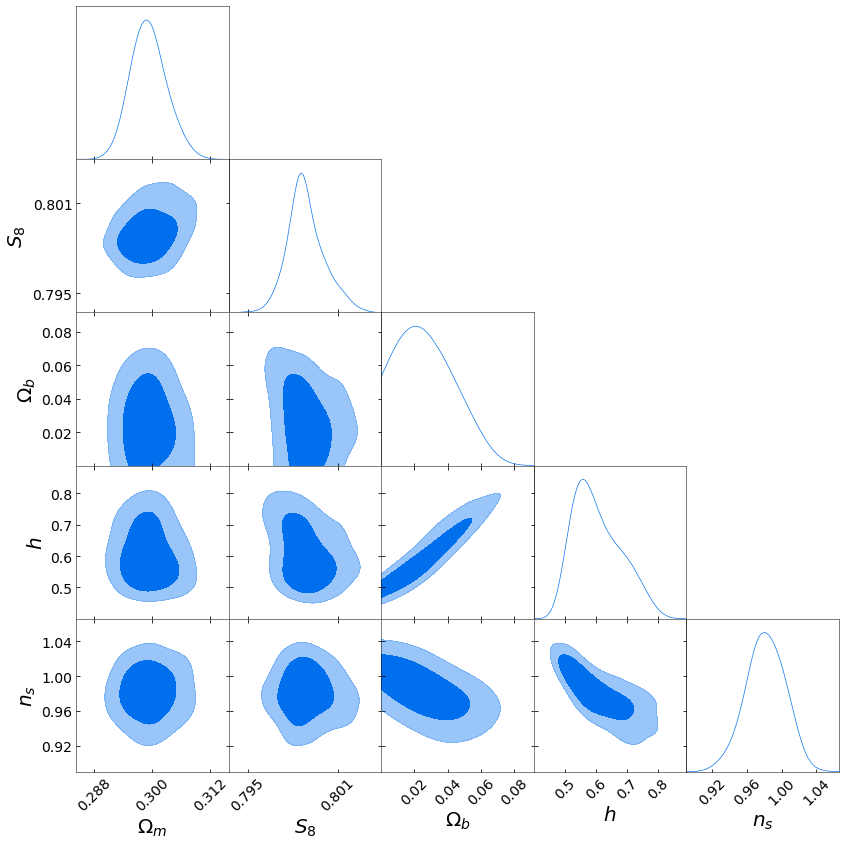

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


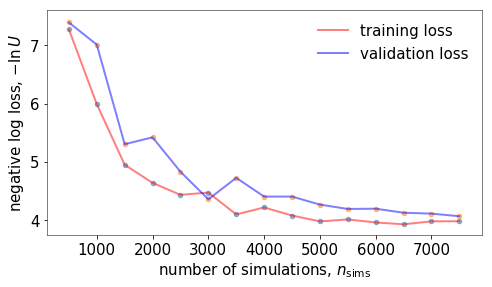

Population 15/23
Sampling proposal density...





















Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...





















Simulations:   0%|          | 1/499 [00:00<04:26,  1.87it/s]


















Simulations:   0%|          | 2/499 [00:01<04:19,  1.92it/s]


















Simulations:   1%|          | 3/499 [00:01<04:01,  2.06it/s]


















Simulations:   1%|          | 4/499 [00:01<03:46,  2.19it/s]


















Simulations:   1%|          | 5/499 [00:02<03:35,  2.29it/s]


















Simulations:   1%|          | 6/499 [00:02<03:28,  2.37it/s]


















Simulations:   1%|▏         | 7/499 [00:02<03:22,  2.43it/s]


















Simulations:   2%|▏         | 8/499 [00:03<03:19,  2.46it/s]


















Simulations:   2%|▏         | 9/499 [00:03<03:16,  2.50it/s]


















Simulations:   2%|▏         | 10/499 [00:04<03:14,  2.51it/s]


















Simulations:   2%|▏         | 11/499 [00:04<03:13,  2.52it/s]


















Simulations:   2%|▏         | 12/499 [00:04<03:12,  2.53it/s]


















Simulations:   3%|▎         | 

Simulations:  24%|██▍       | 119/499 [00:50<02:30,  2.53it/s]


















Simulations:  24%|██▍       | 120/499 [00:50<02:30,  2.53it/s]

In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
DelfiMAF.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10)

In [ ]:
plt.close()
columnwidth = 18 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 15,
                 'legend.fontsize': 15,
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})

# Trace plot of the training and validation loss as a function of the number of simulations ran
plt.scatter(DelfiMAF.sequential_nsims, DelfiMAF.sequential_training_loss, s = 20, alpha = 0.5)
plt.plot(DelfiMAF.sequential_nsims, DelfiMAF.sequential_training_loss, color = 'red', lw = 2, alpha = 0.5, label = 'training loss')
plt.scatter(DelfiMAF.sequential_nsims, DelfiMAF.sequential_validation_loss, s = 20, alpha = 0.5)
plt.plot(DelfiMAF.sequential_nsims, DelfiMAF.sequential_validation_loss, color = 'blue', lw = 2, alpha = 0.5, label = 'validation loss')


#plt.fill_between(DelfiMAF.sequential_nsims, (DelfiMAF.sequential_validation_loss[-1]-0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), 
#                 (DelfiMAF.sequential_validation_loss[-1]+0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), color = 'grey', alpha = 0.2 )

plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log loss, $-\mathrm{ln}\,U$')
#plt.savefig('../../paper_II/plots/convergence_fixedII.pdf')
plt.tight_layout()
plt.legend()
plt.show()